# Dataloading

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from qscaled.preprocessing import bootstrap_crossings, FullGroupedLoaderUnlabeled
from qscaled.visualization import plot_per_batch_size, plot_per_lr
from qscaled.bootstrap_envsteps_to_thresh import (
    grid_best_uncertainty_lr,
    grid_best_uncertainty_bs,
    get_bootstrap_optimal,
    compute_bootstrap_averages,
    plot_bootstrap_average_params,
    linear_fit_separate,
    linear_fit_shared,
    tabulate_proposed_params,
    tabulate_baseline_params
)

from utils.create_zip import save_and_load
from utils.configs import Config

np.random.seed(42)

To use this code:
1. Label your Wandb runs with tags.
2. Fill in `MyRunCollector` in `utils/wandb_utils.py`.
3. Update the following cell.

The latter two steps take ~5 minutes!

If you set `wandb_collect == True`, your `zip` file will be rebuilt using your
Wandb collector. Otherwise, the `zip` file must be present.

In [6]:
wandb_collect = False
wandb_collector = None  # Zip data was collected separately.
name = 'dmc_sweep'

# Maximum possible returns (estimated with infinite data and compute) on each
# environment. These are mostly eyeballed such that runs reach 80% (hence
# the 1.25 multiplier) but not 90%. There is some variation for different environments.

config = Config(
    name=name,
    max_returns={},  # No need to normalize returns, DMC is already 0-1000.
    return_key=None,  # Not present in zip data.
    utds_to_predict=[0.25, 0.5, 1, 2, 4, 8, 16],
    wandb_collector=wandb_collector,
    zip_load_cls=FullGroupedLoaderUnlabeled,
    env_step_freq=1000,
    env_step_start=5000
)

**Note:** Due to bootstrapping, outputs are randomized. We have set a random seed,
so if you restart the kernel and run all cells, your final `csv` output should
be deterministic.

If you used the code above with `save_loop`, use `UTDGroupedLoader` below.
(`FullGroupedLoaderUnlabeled` is used below for DMC data, which was collected independently.)

In [7]:
grid_search_df, (envs, utds, batch_sizes, learning_rates) = save_and_load(config)

grid_search_df = bootstrap_crossings(
    grid_search_df, 
    config.thresholds, 
    bootstrap_cache_file=f'../../cache/bootstrap_results/{name}.pkl'
)

Average standard deviation across all conditions: 9428.81


# Visualization

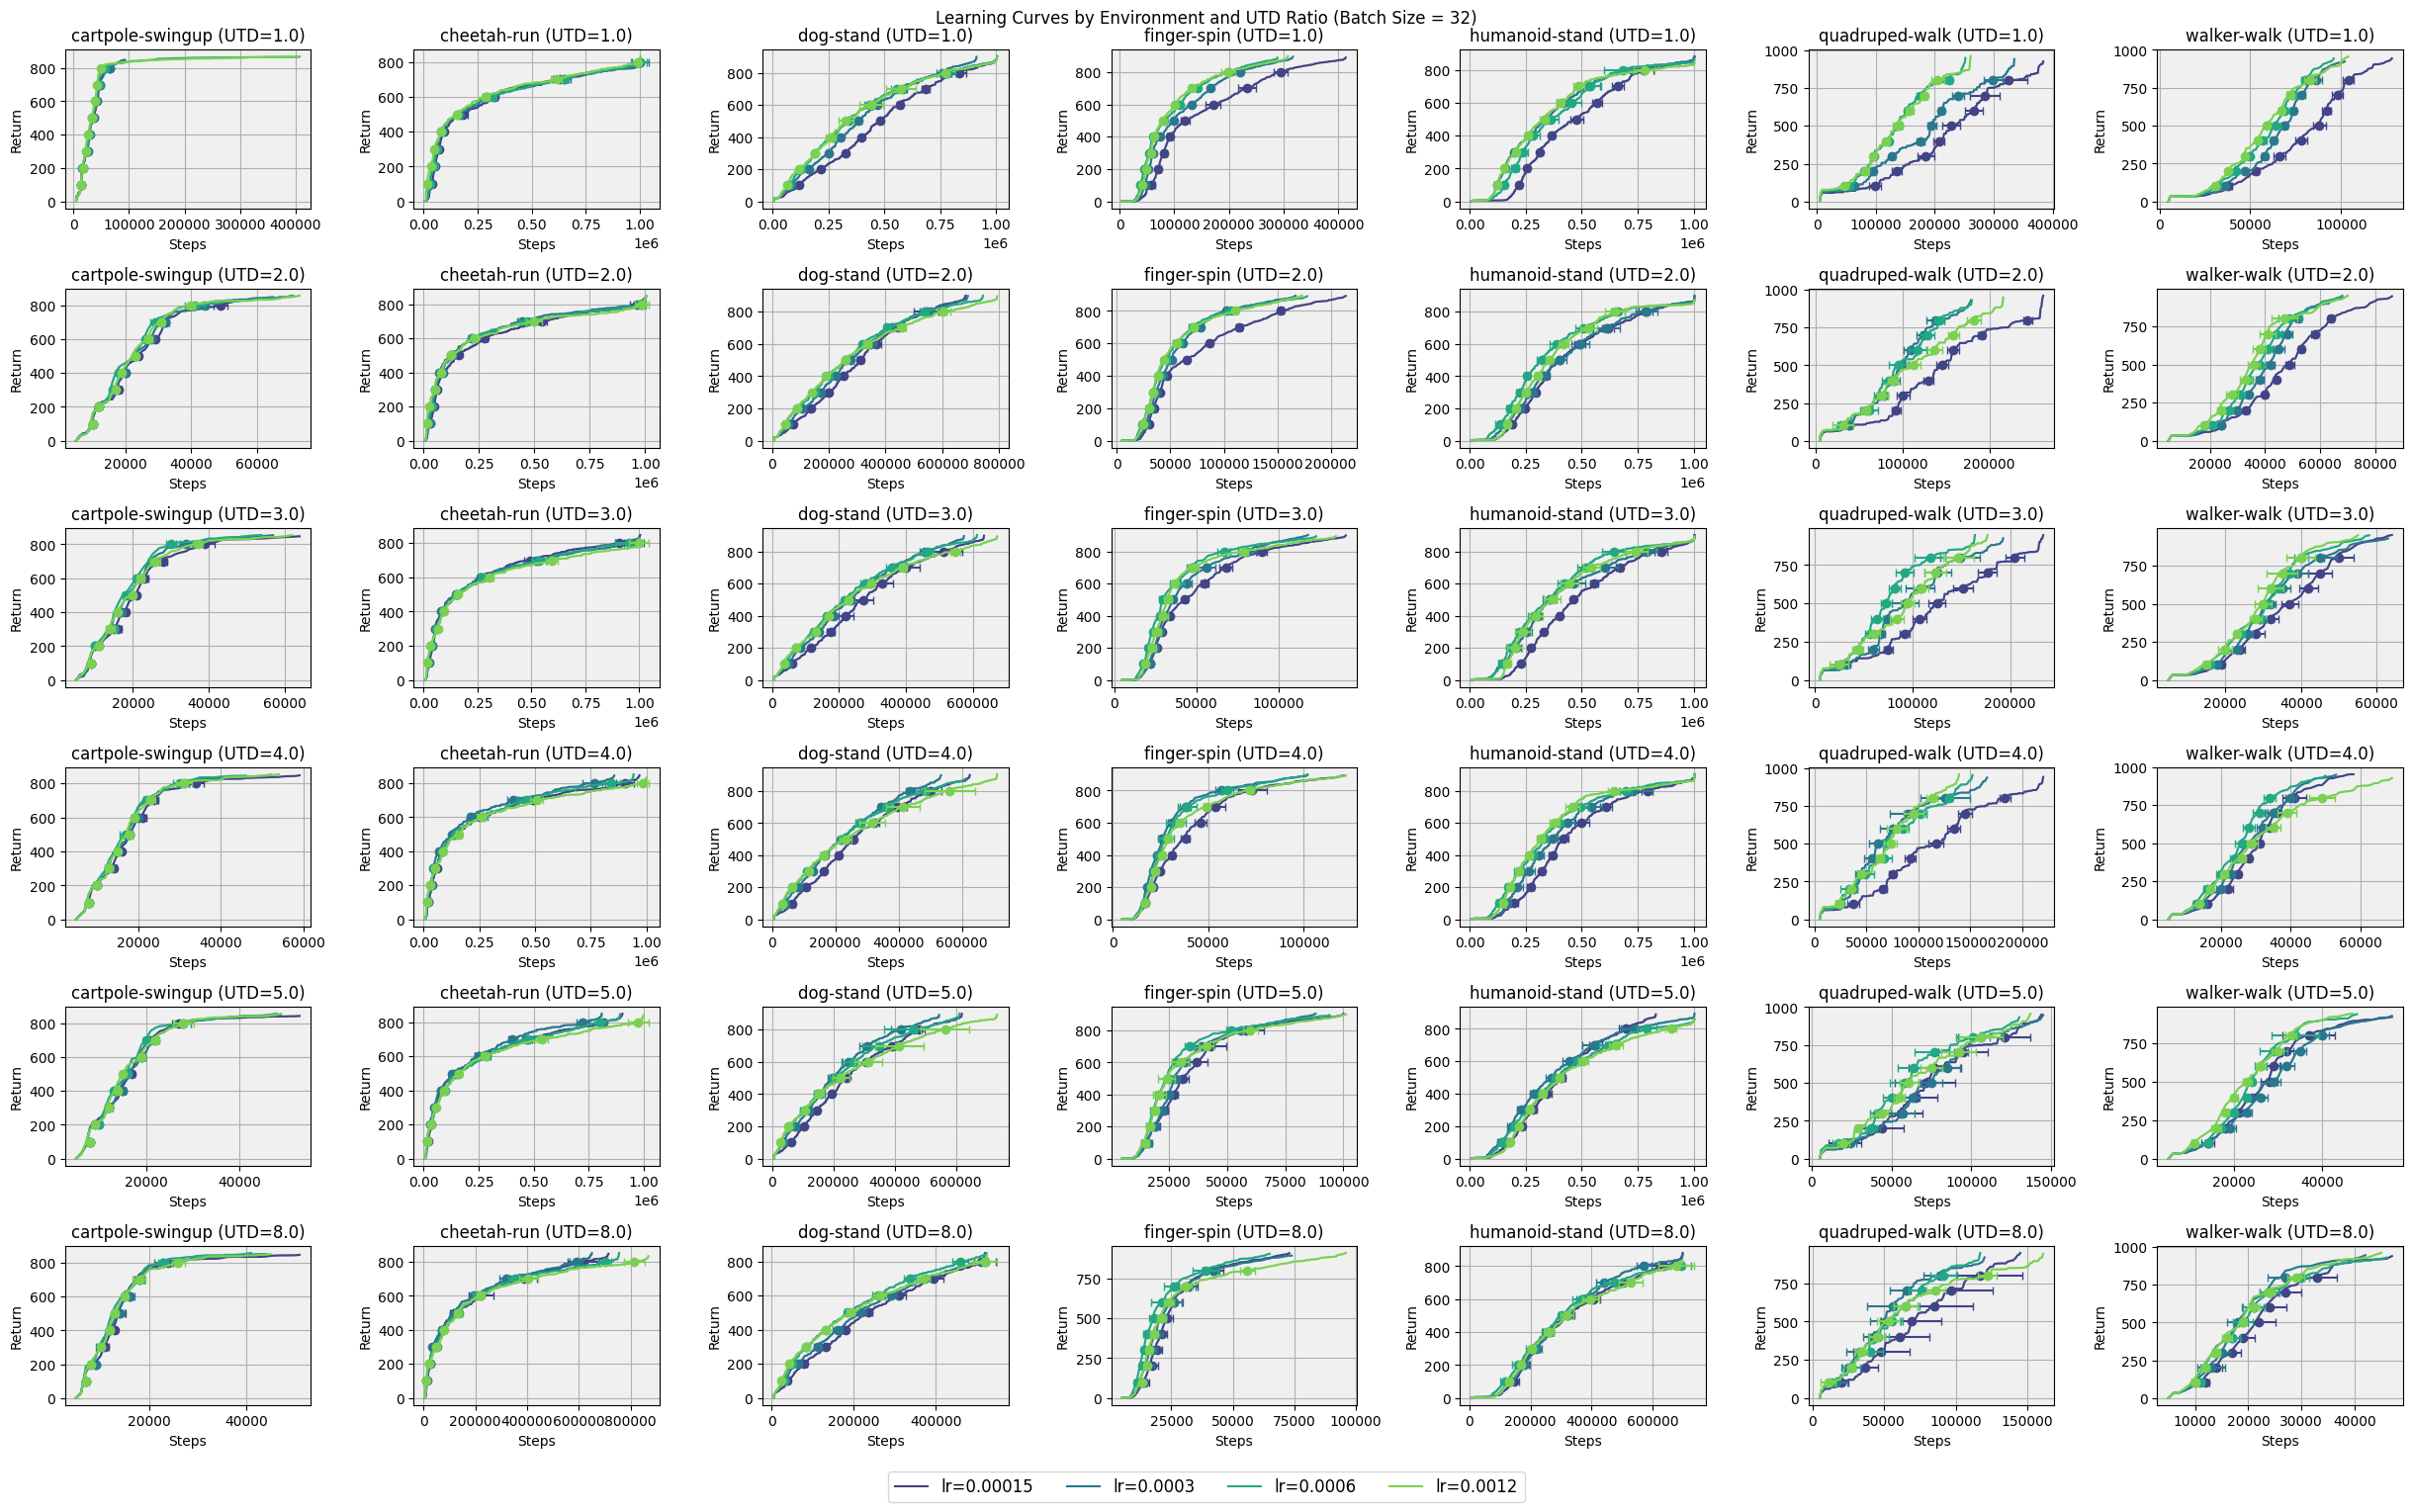

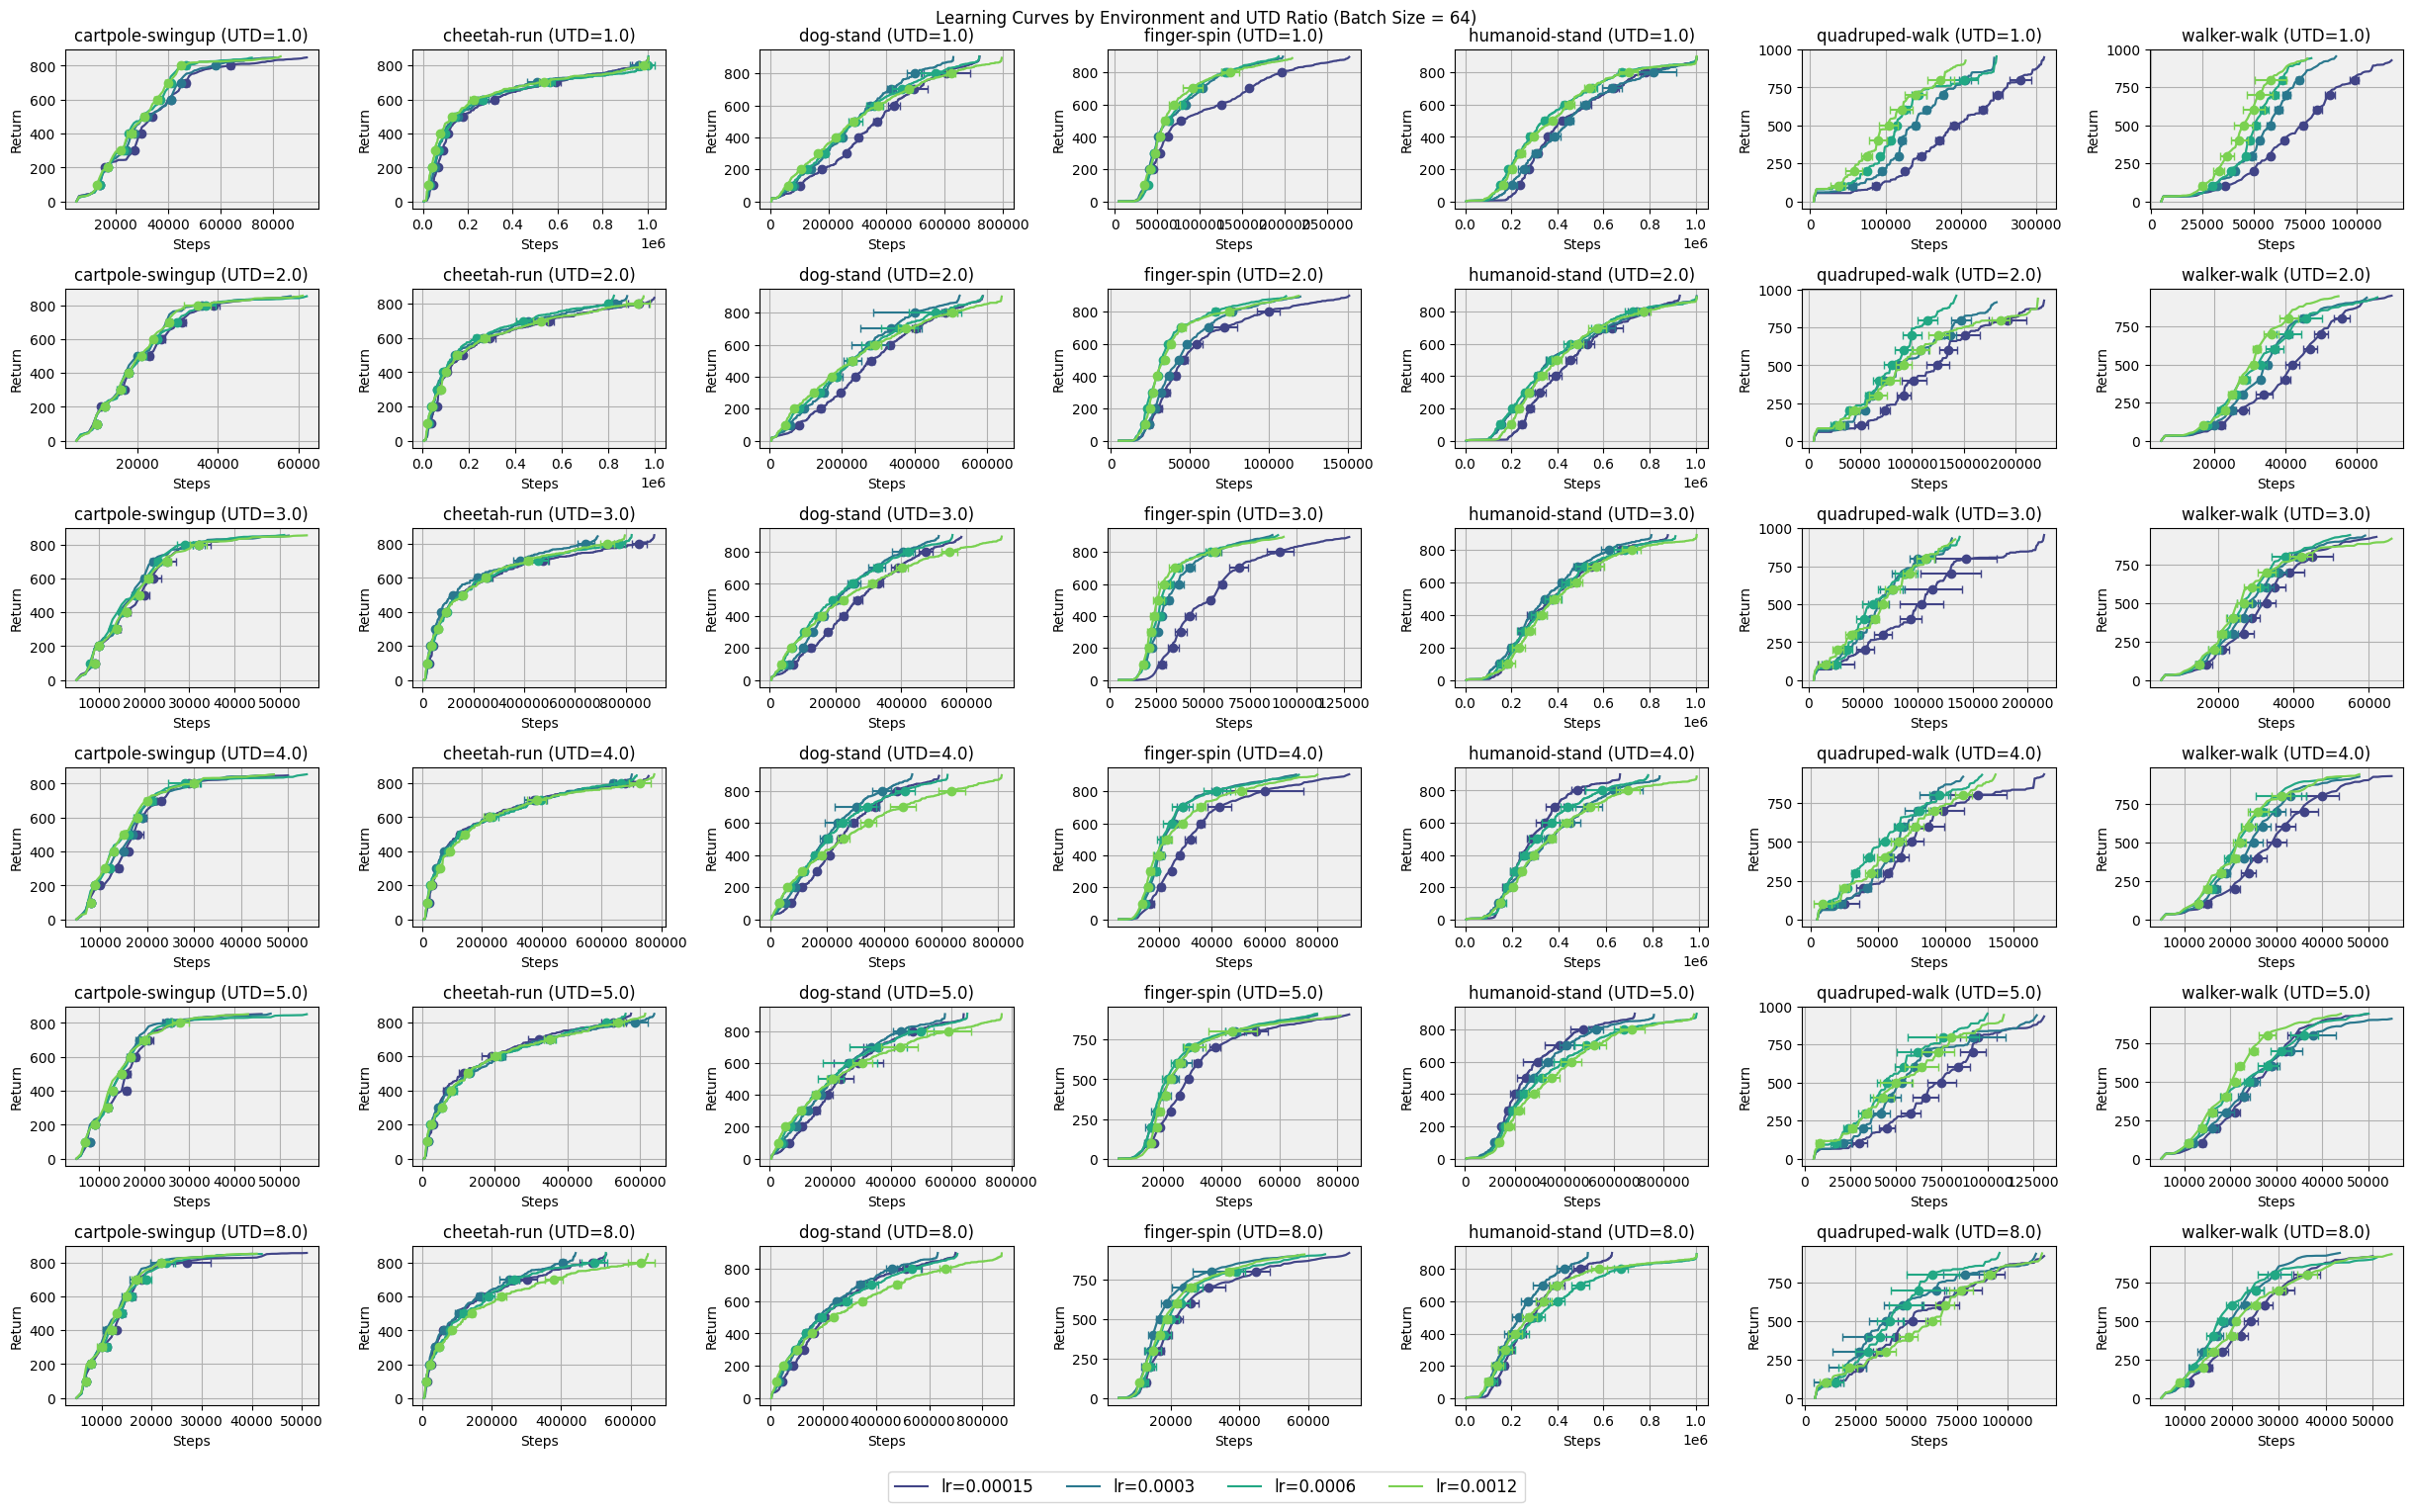

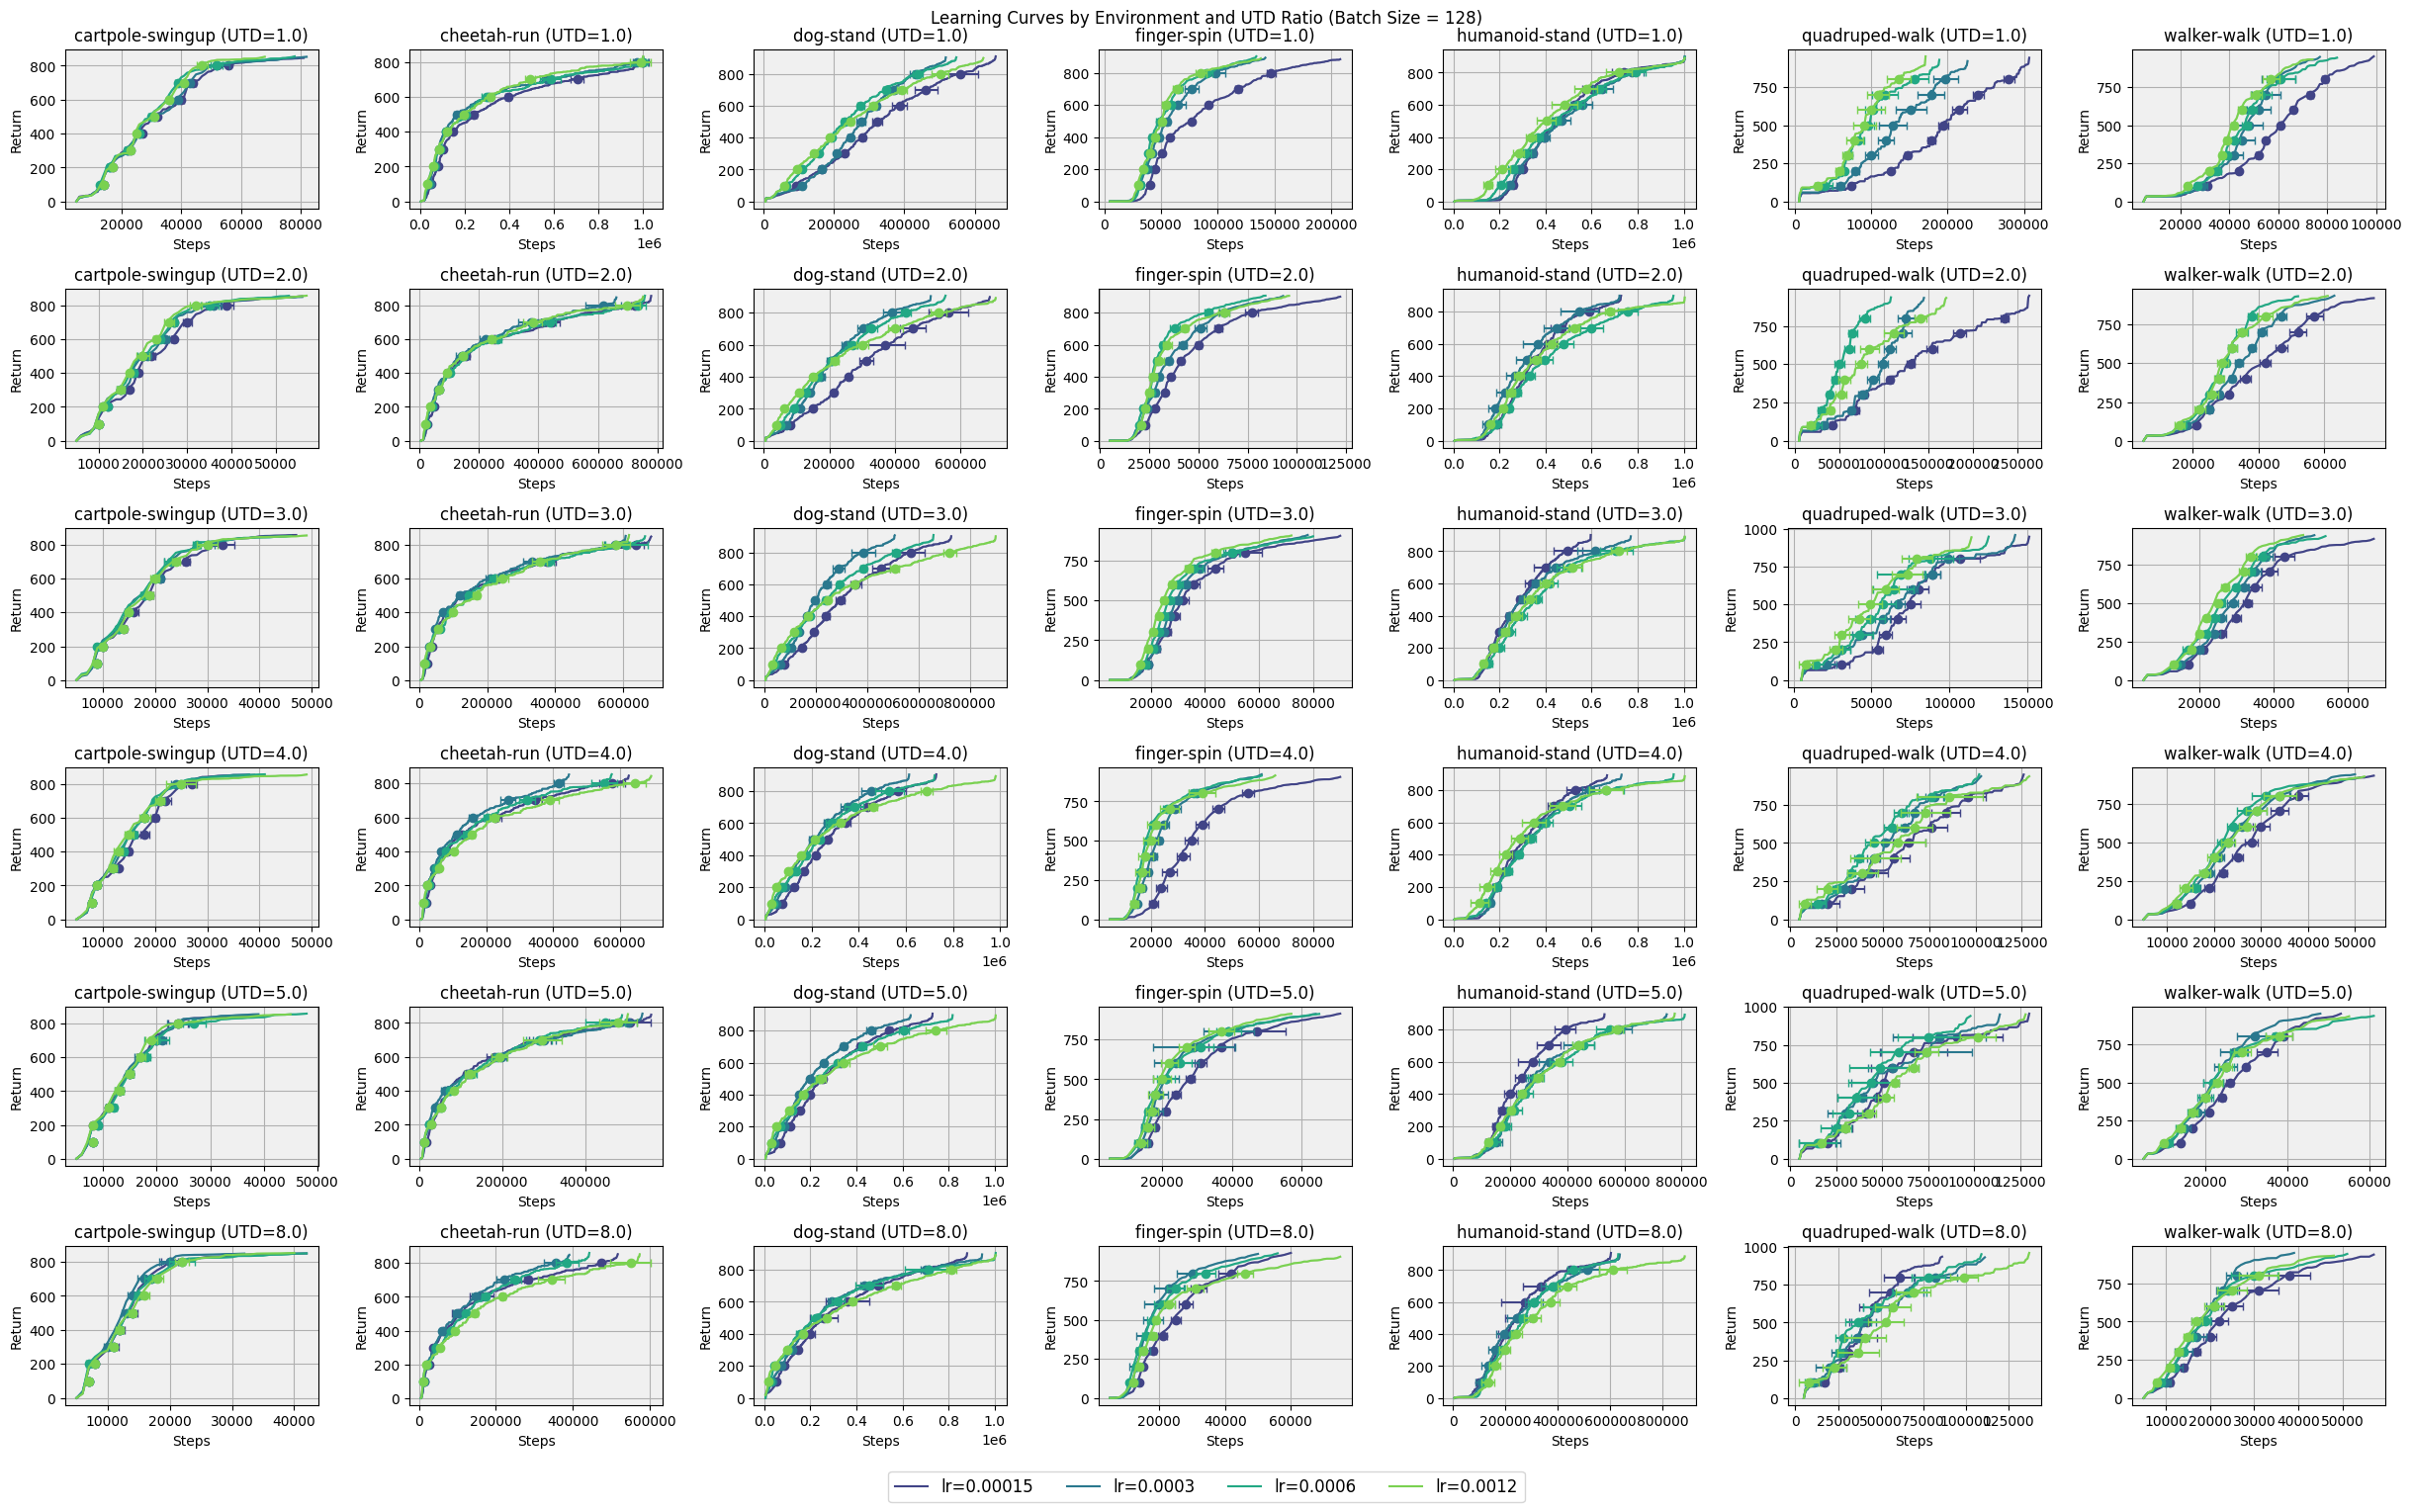

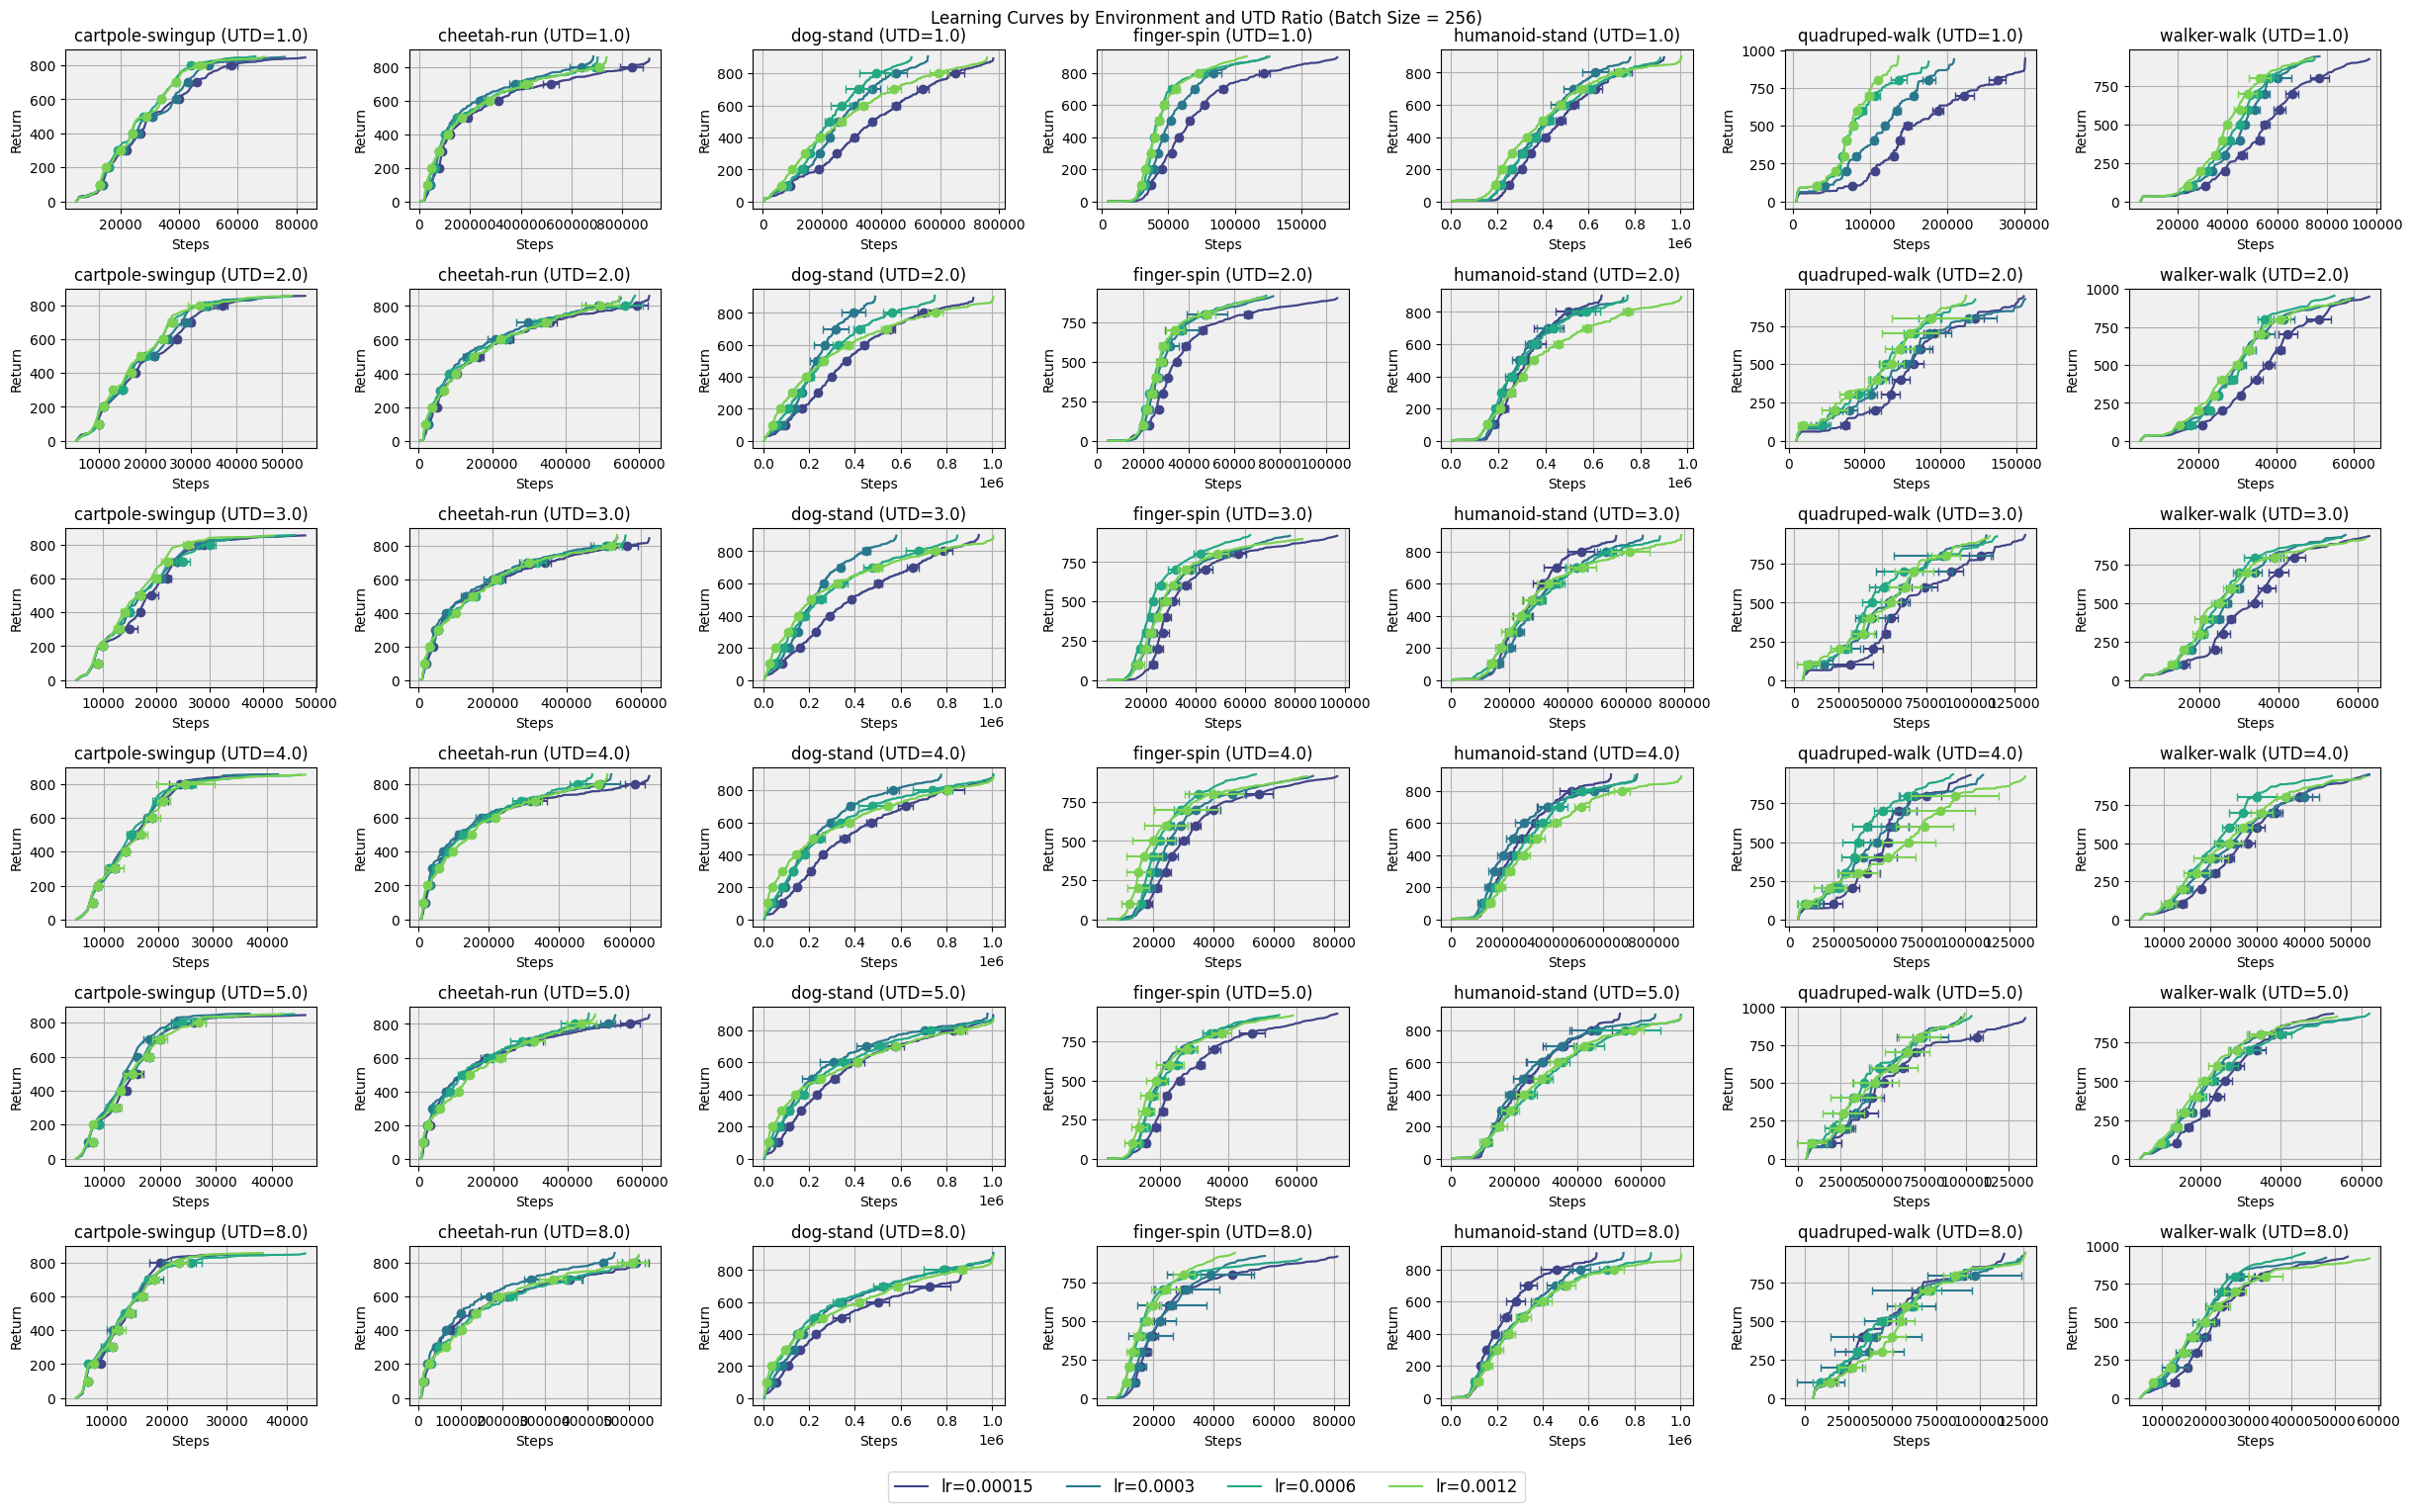

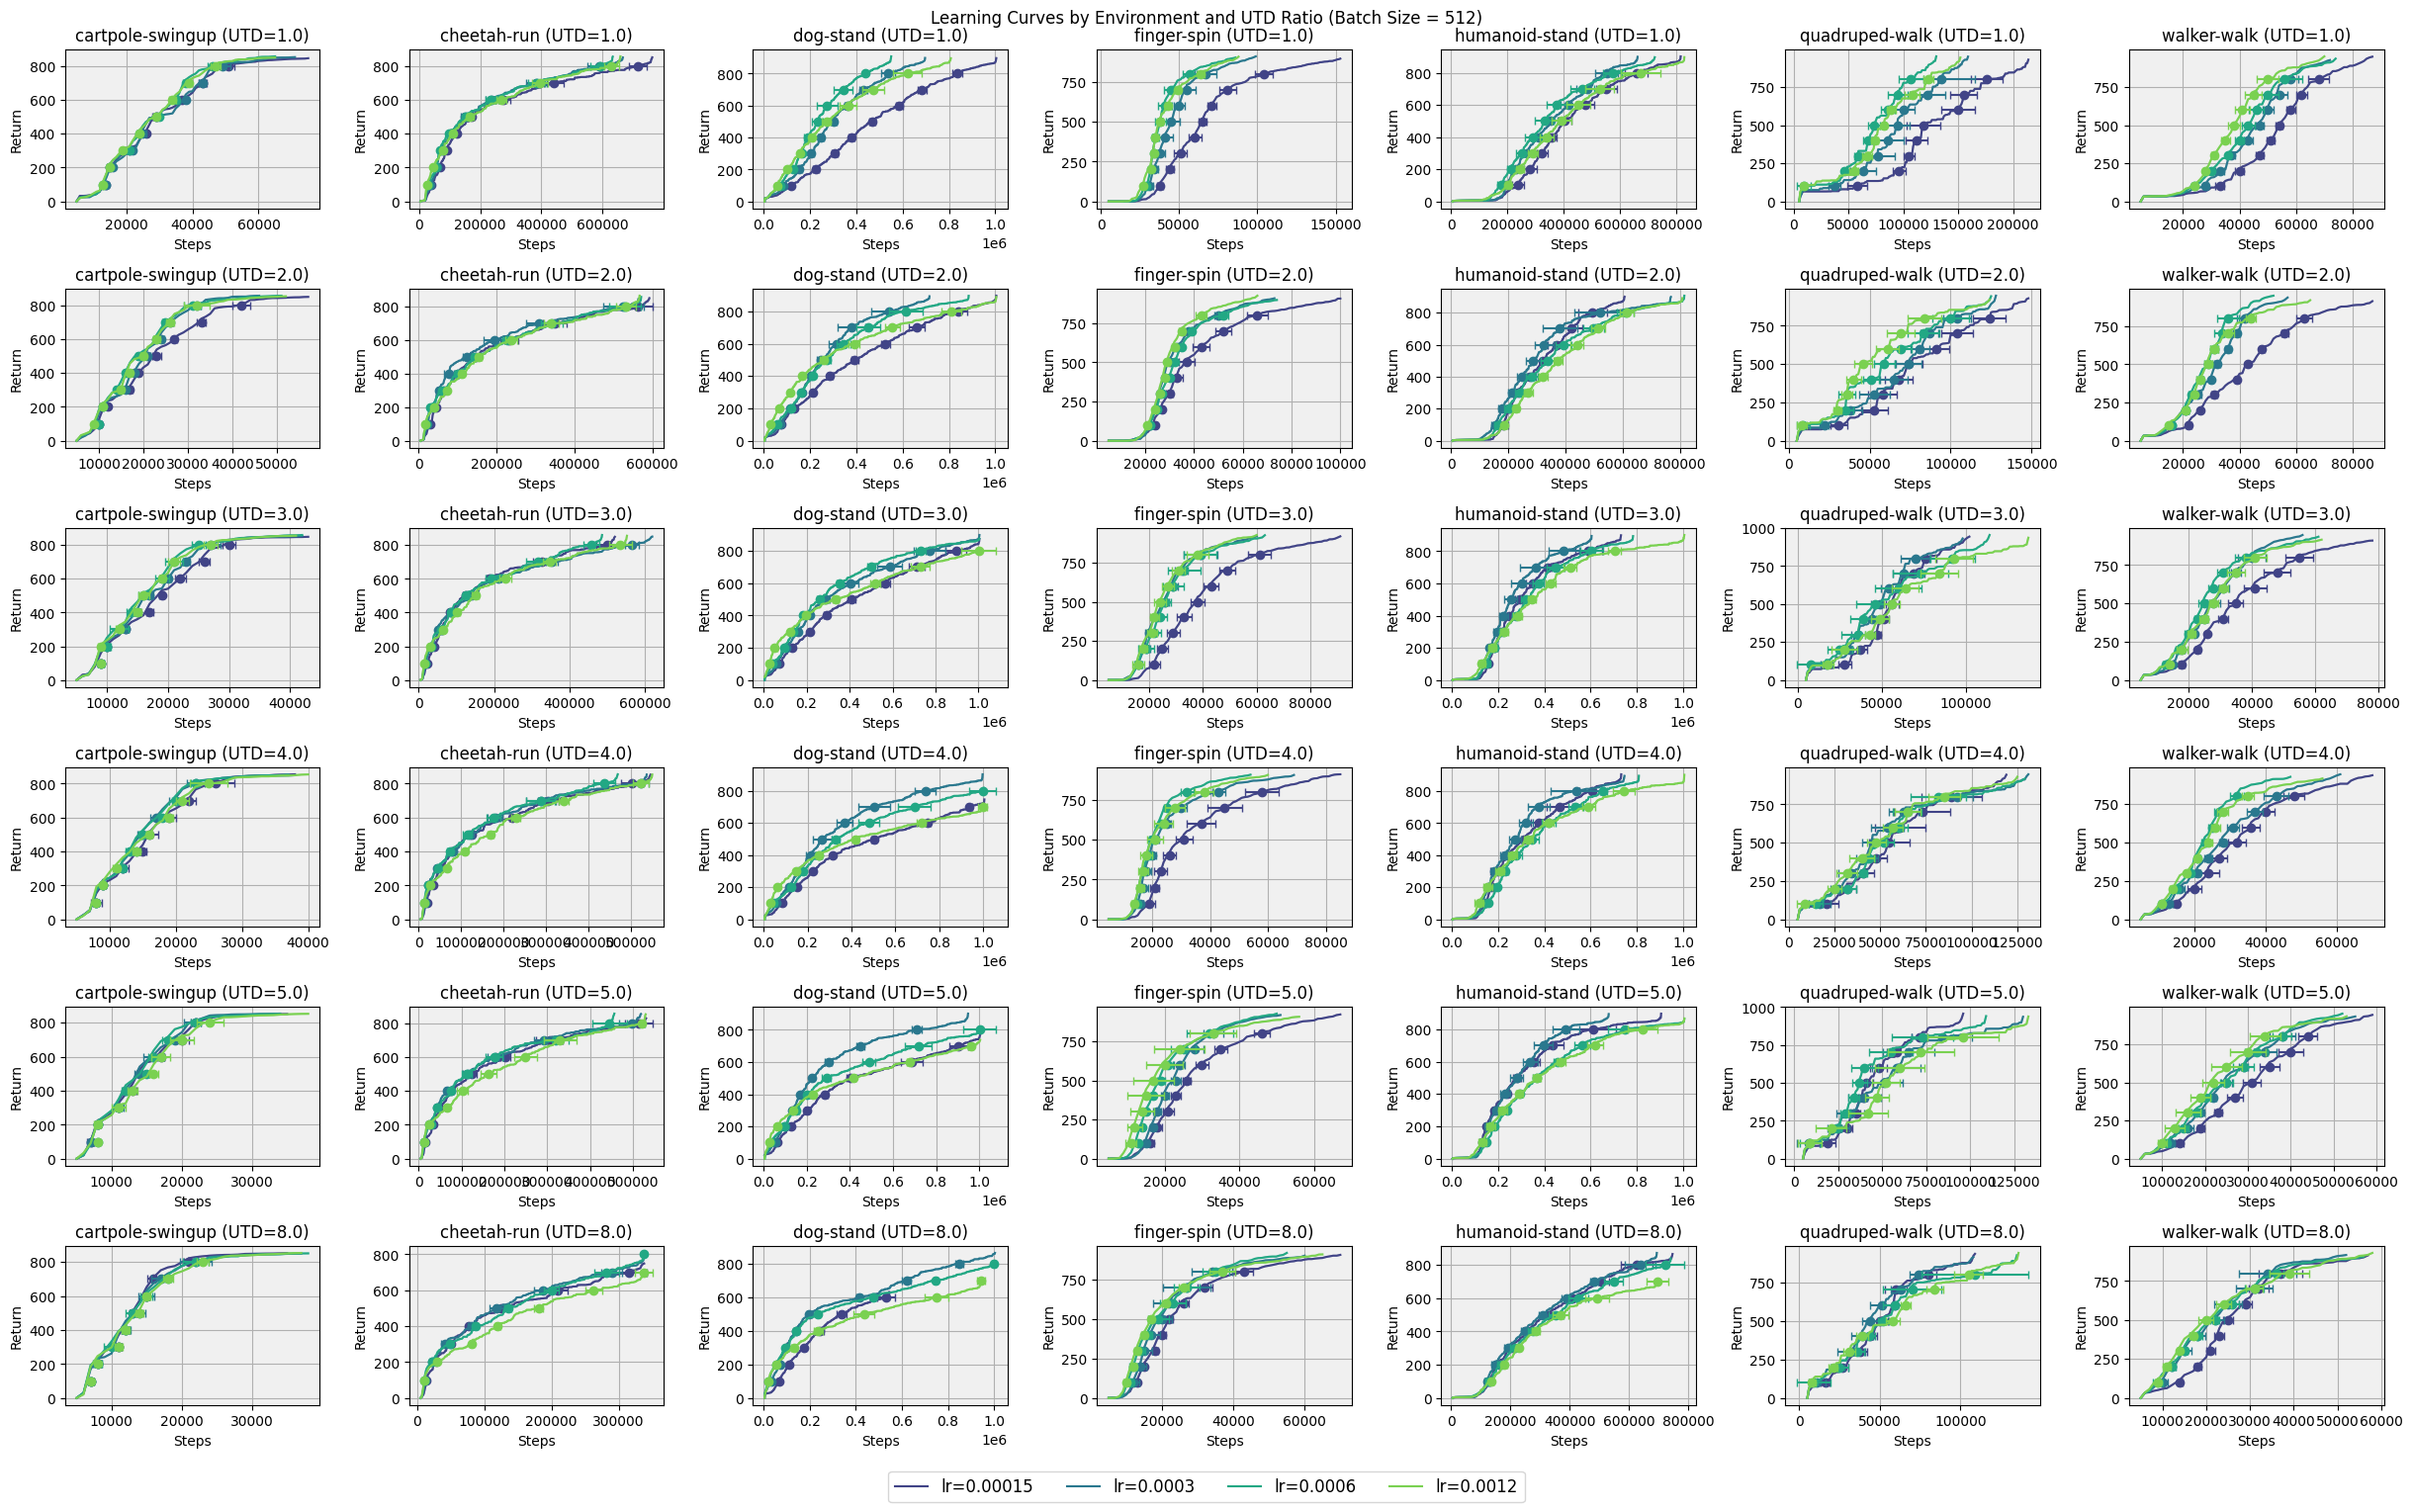

In [8]:
plot_per_batch_size(grid_search_df, len(utds), len(envs), batch_sizes, config.thresholds)

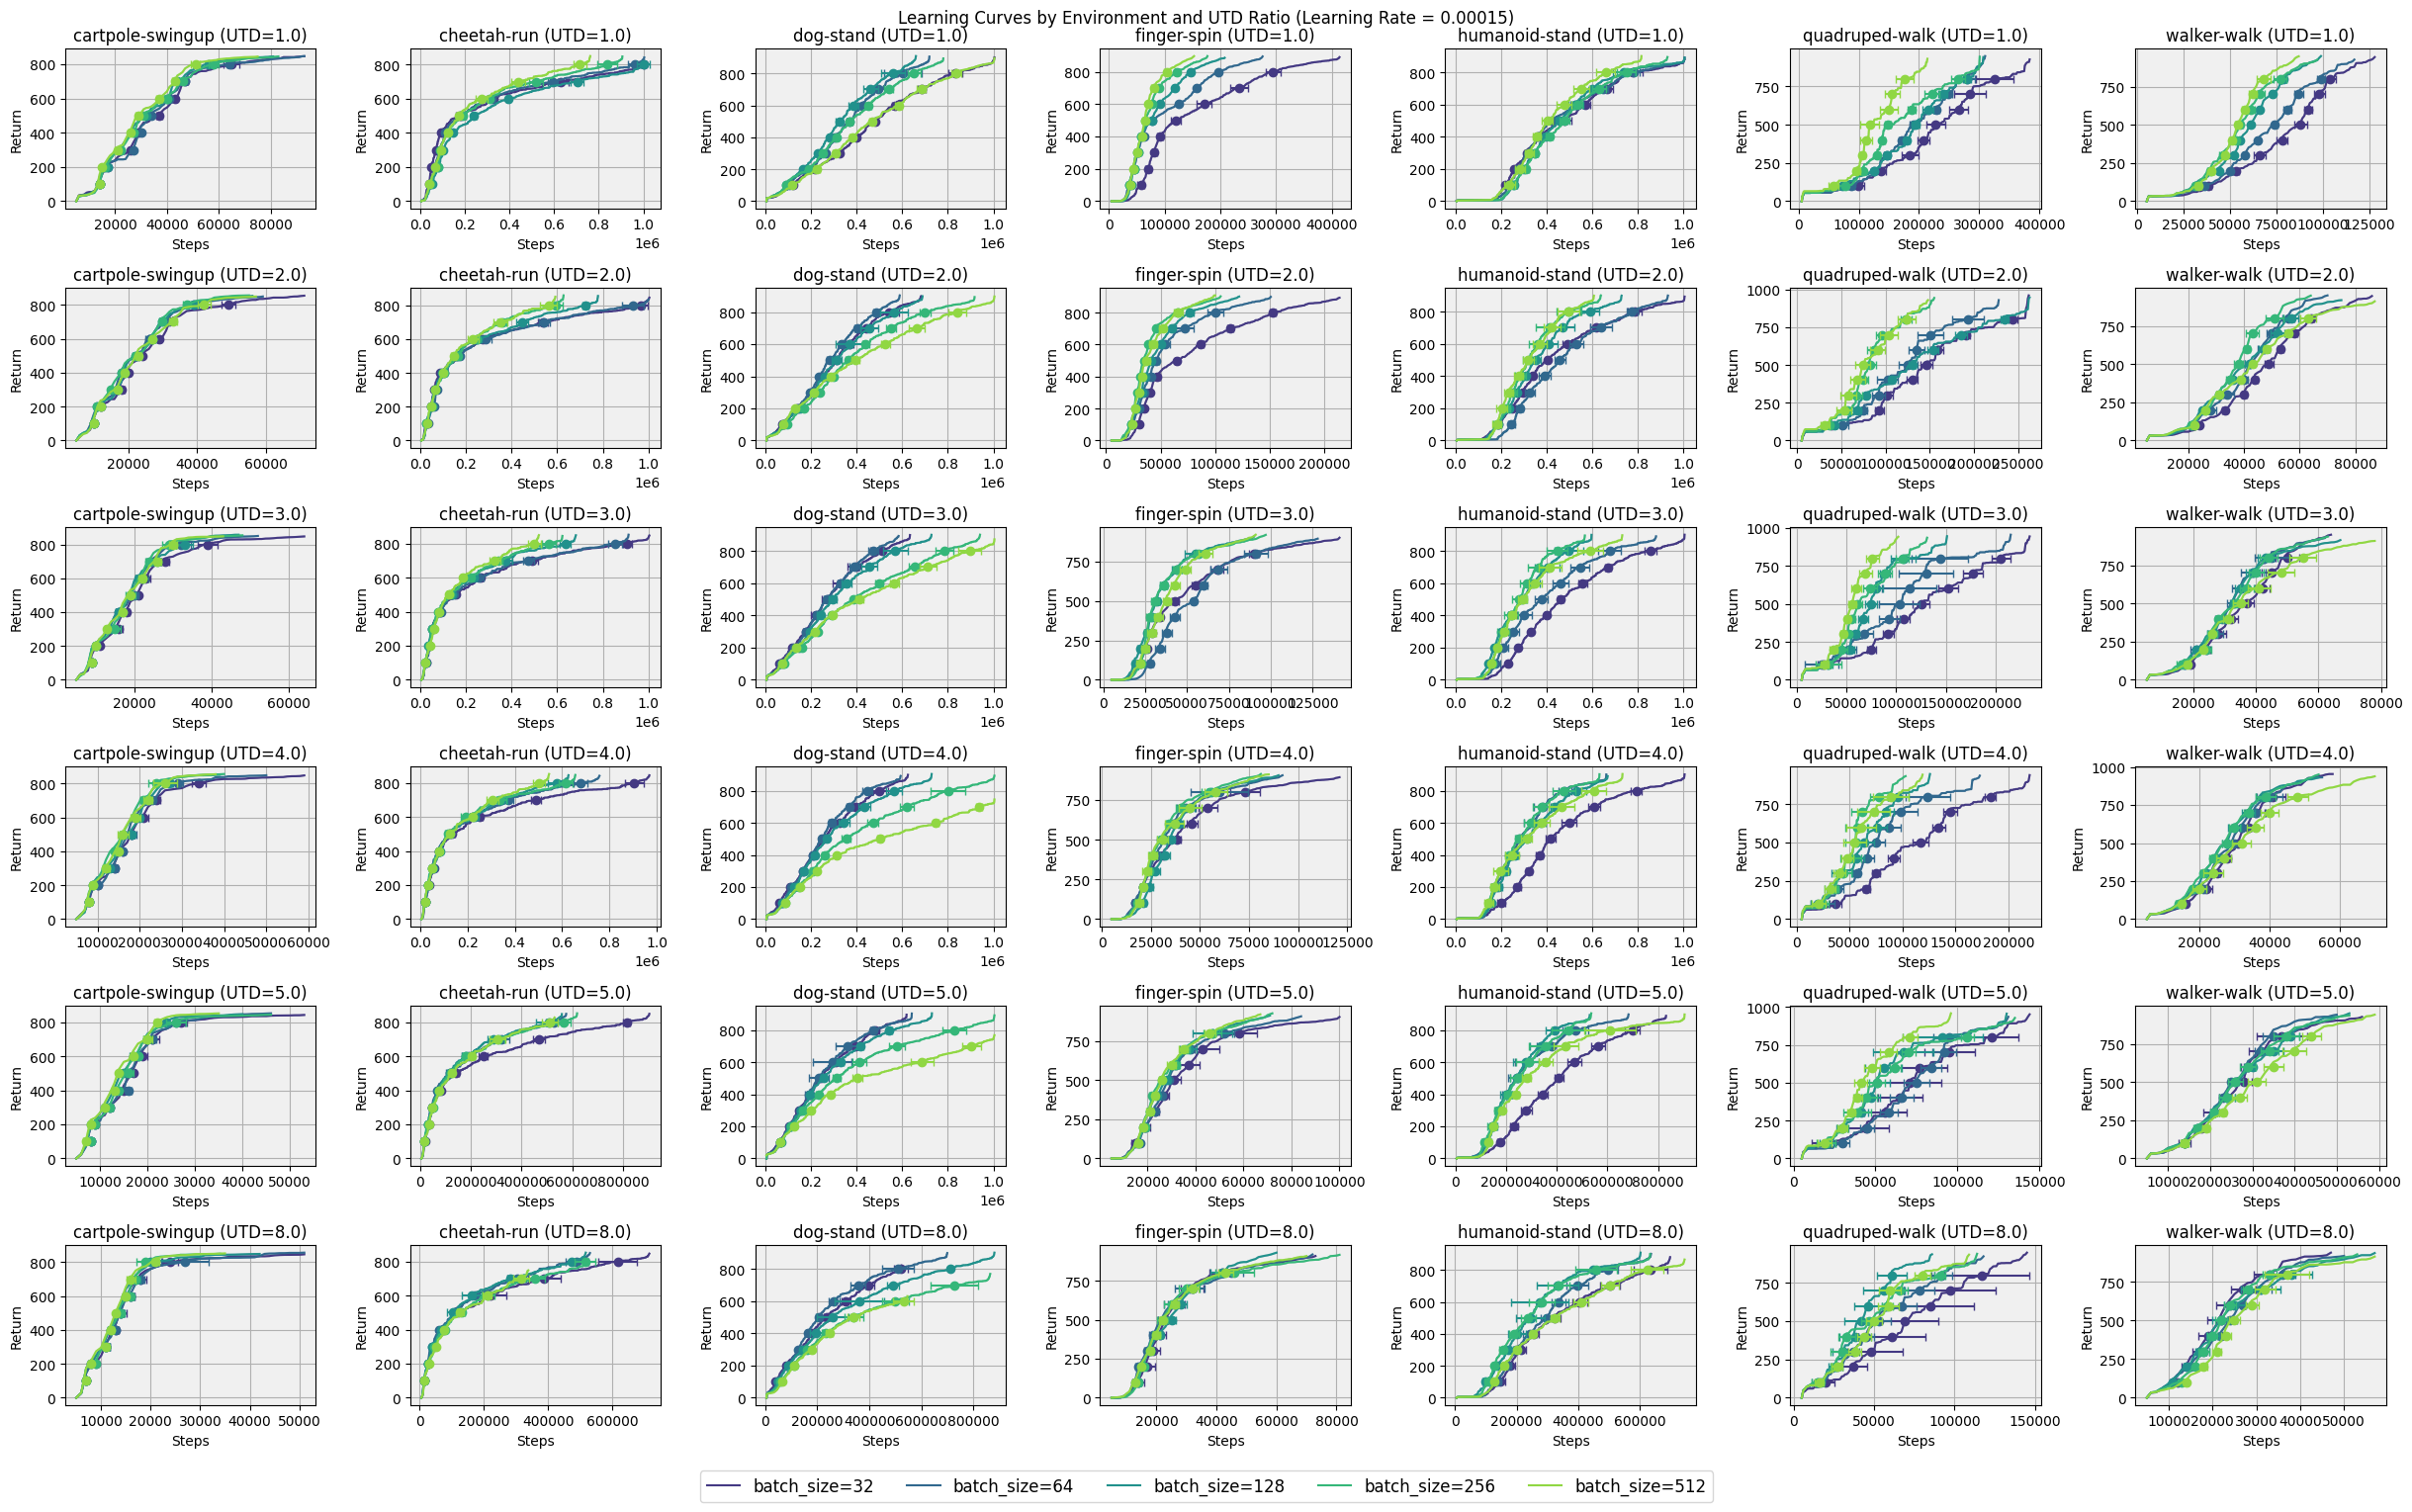

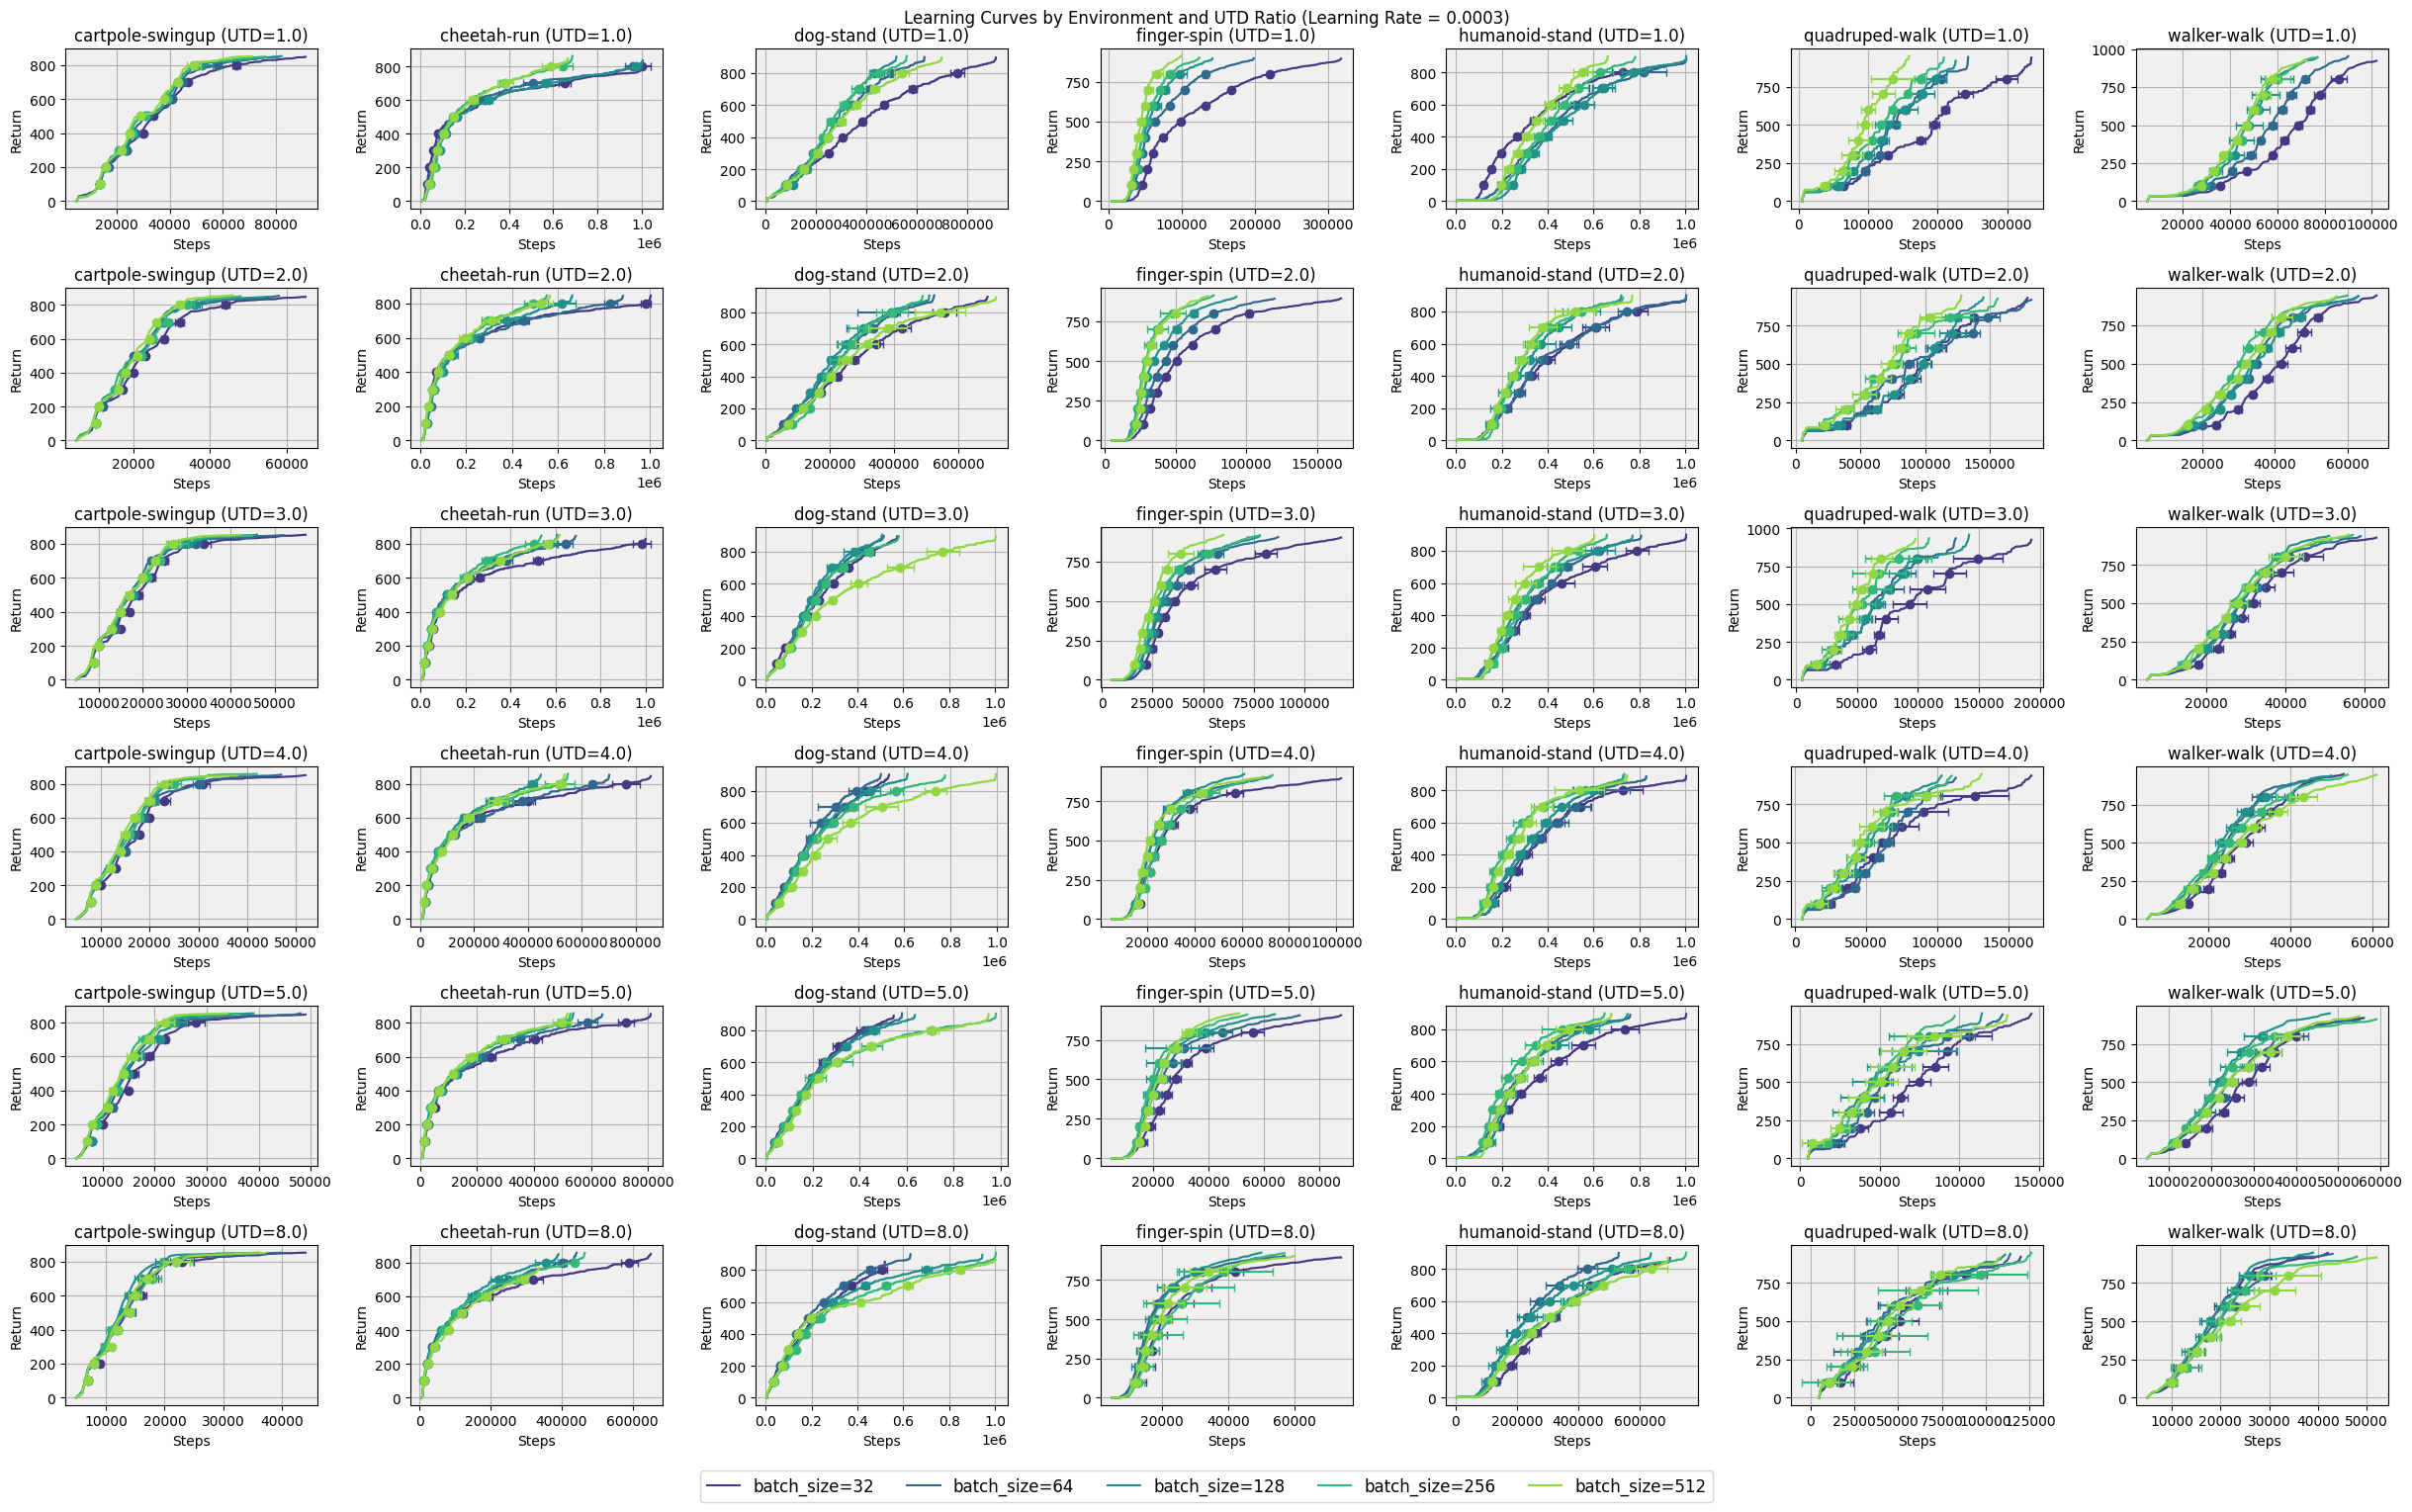

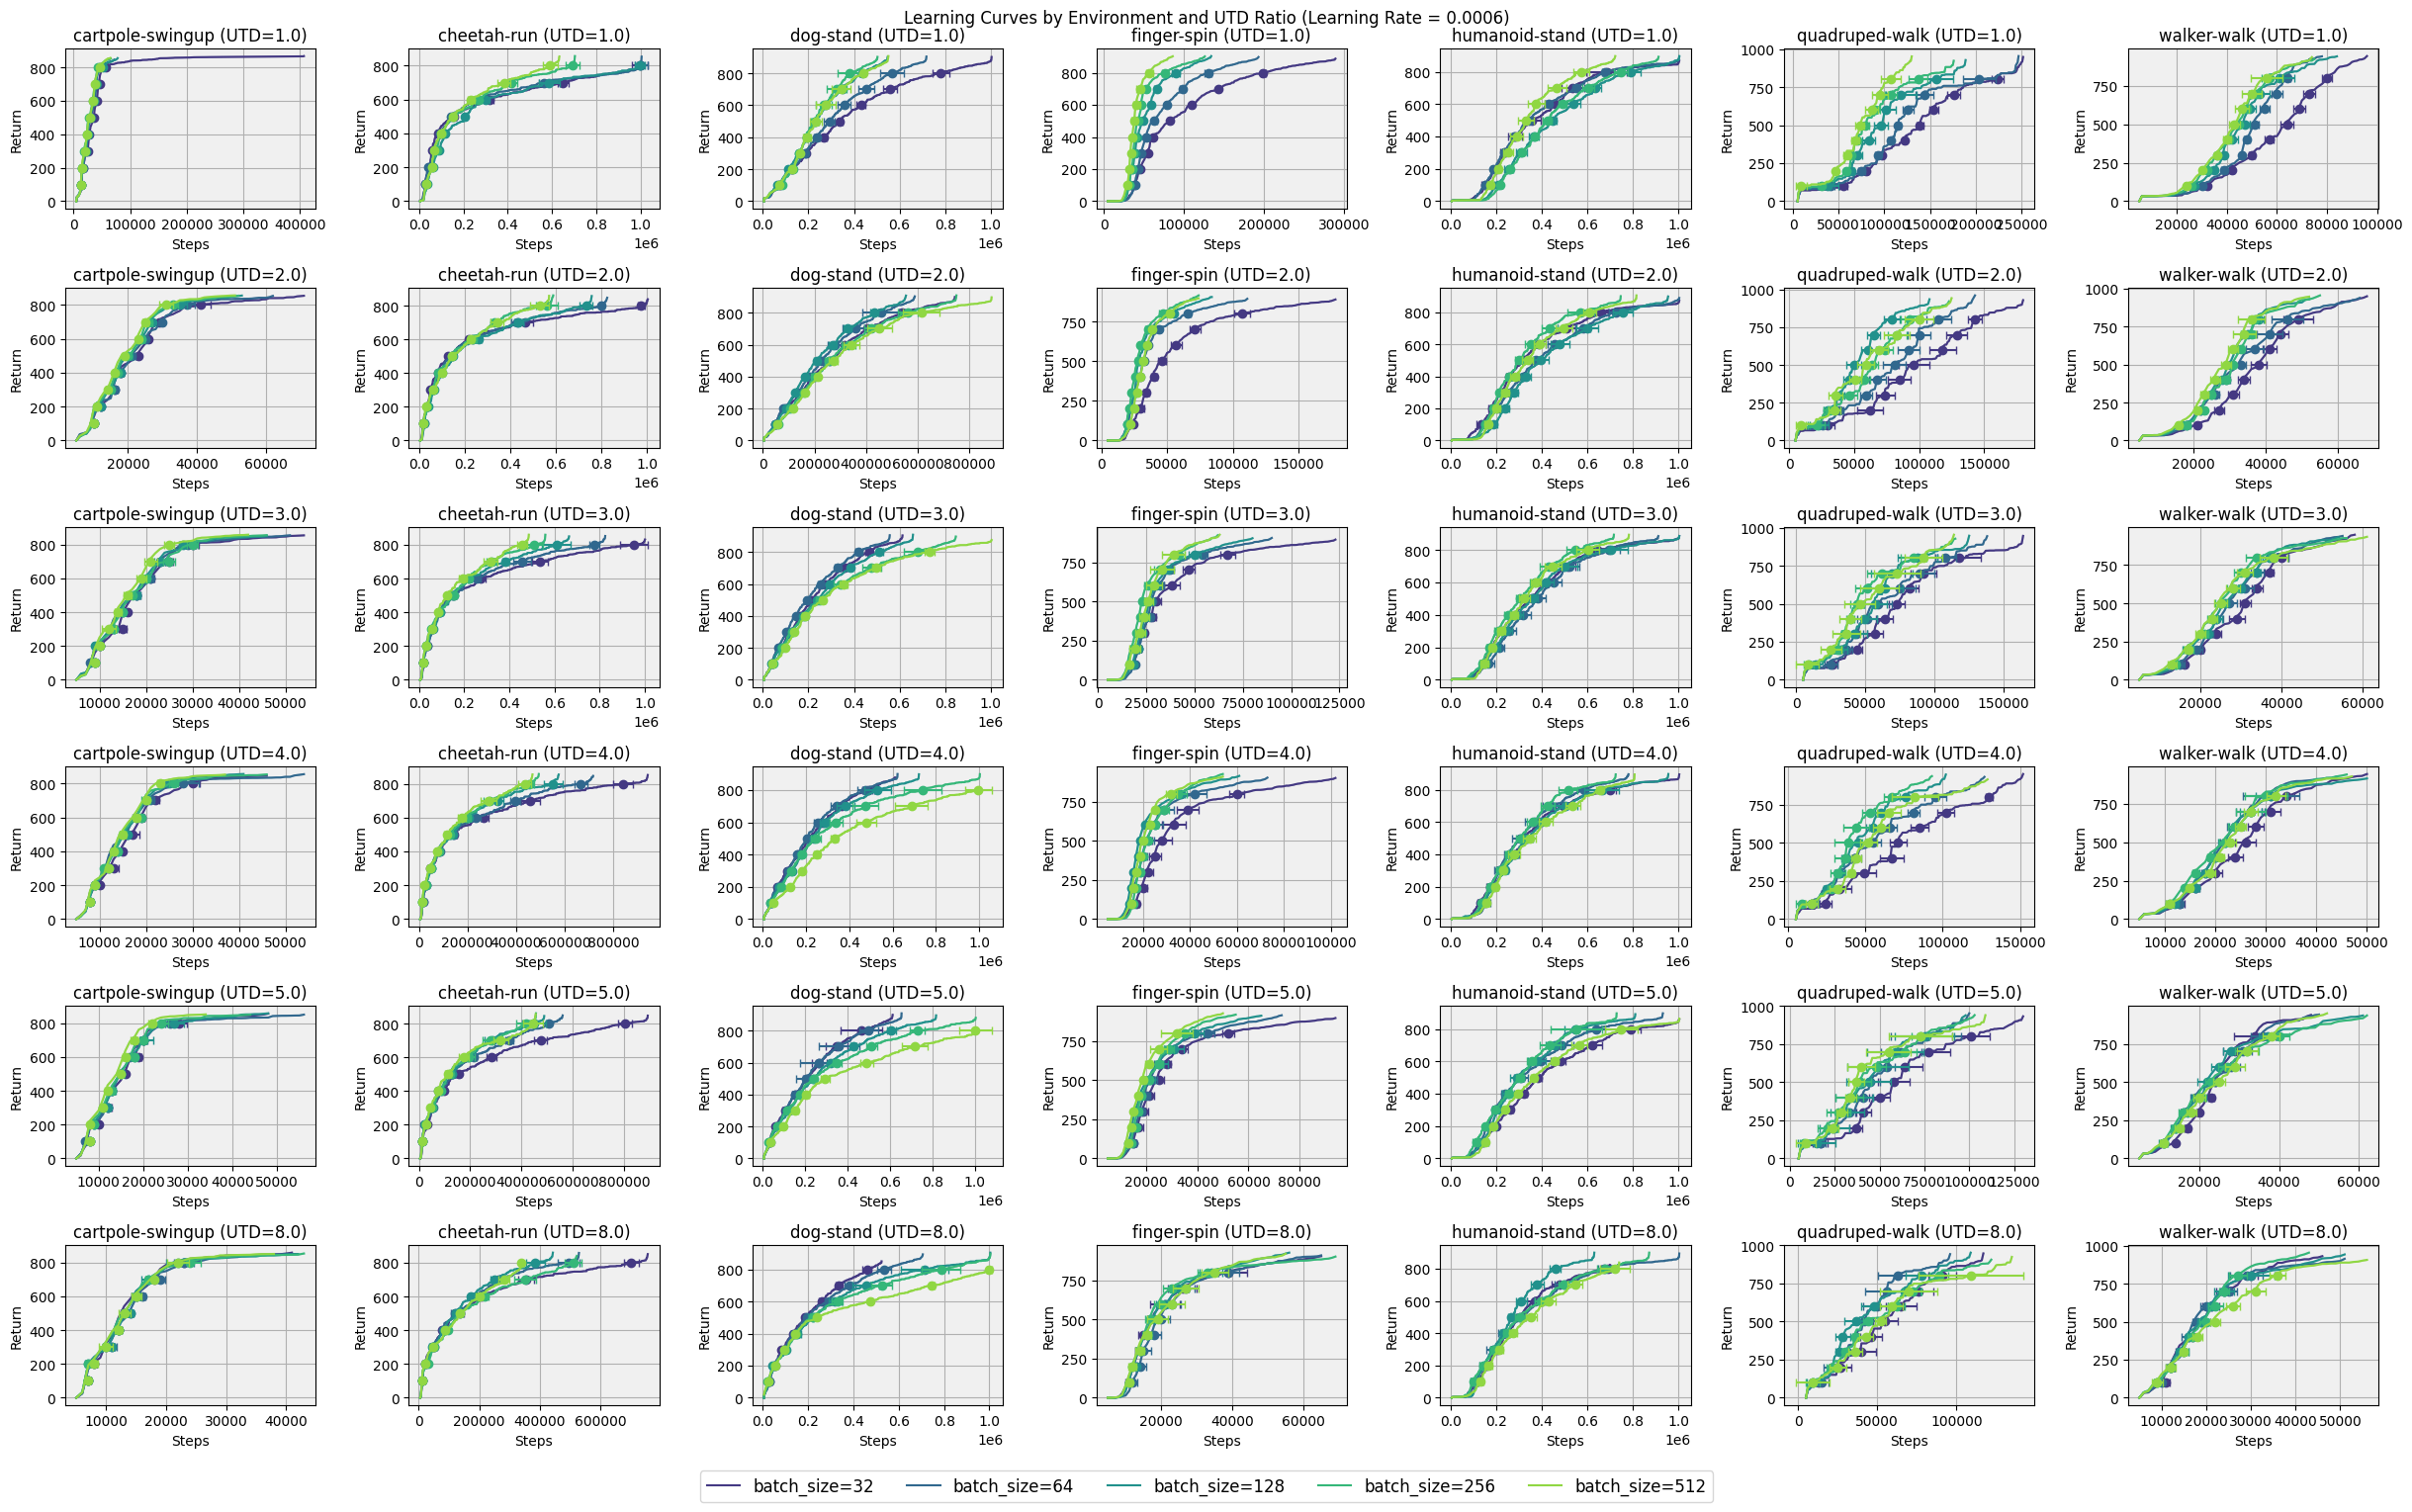

In [9]:
plot_per_lr(grid_search_df, len(utds), len(envs), learning_rates, config.thresholds)

# Bootstrapping

In [10]:
best_lr = grid_best_uncertainty_lr(grid_search_df, print_pivot=True)


Best Learning Rates:
env_name   cartpole-swingup                                 cheetah-run                                 dog-stand                                 finger-spin                                 humanoid-stand                                 quadruped-walk                                 walker-walk                                
batch_size              32      64      128     256     512         32      64      128     256     512       32      64      128     256     512         32      64      128     256     512            32      64      128     256     512            32      64      128     256     512         32      64      128     256     512
utd                                                                                                                                                                                                                                                                                                                               

In [11]:
best_bs = grid_best_uncertainty_bs(grid_search_df, print_pivot=True)


Best Batch Sizes:
env_name      cartpole-swingup                         cheetah-run                         dog-stand                         finger-spin                         humanoid-stand                         quadruped-walk                         walker-walk                        
learning_rate          1.5e-04 3.0e-04 6.0e-04 1.2e-03     1.5e-04 3.0e-04 6.0e-04 1.2e-03   1.5e-04 3.0e-04 6.0e-04 1.2e-03     1.5e-04 3.0e-04 6.0e-04 1.2e-03        1.5e-04 3.0e-04 6.0e-04 1.2e-03        1.5e-04 3.0e-04 6.0e-04 1.2e-03     1.5e-04 3.0e-04 6.0e-04 1.2e-03
utd                                                                                                                                                                                                                                                                               
1.0e+00                    512     512     256      64         512     512     512     512       128     128     256     128         512     512     512    

In [12]:
best_lr_bs = best_lr.groupby(['env_name', 'utd']).apply(get_bootstrap_optimal, include_groups=False).reset_index()
best_lr_bs = compute_bootstrap_averages(best_lr, best_bs, best_lr_bs)
best_lr_bs

env_name     utd  best_lr  best_bs  time_to_threshold  \
0   cartpole-swingup 1.0e+00  6.0e-04      256            4.4e+04   
1   cartpole-swingup 2.0e+00  6.0e-04      512            3.1e+04   
2   cartpole-swingup 3.0e+00  6.0e-04      512            2.5e+04   
3   cartpole-swingup 4.0e+00  3.0e-04      512            2.3e+04   
4   cartpole-swingup 5.0e+00  1.5e-04      512            2.2e+04   
5   cartpole-swingup 8.0e+00  1.5e-04      256            1.9e+04   
6        cheetah-run 1.0e+00  3.0e-04      512            5.9e+05   
7        cheetah-run 2.0e+00  3.0e-04      256            4.9e+05   
8        cheetah-run 3.0e+00  6.0e-04      512            4.6e+05   
9        cheetah-run 4.0e+00  3.0e-04      128            4.2e+05   
10       cheetah-run 5.0e+00  6.0e-04      256            4.2e+05   
11       cheetah-run 8.0e+00  6.0e-04      512            3.4e+05   
12         dog-stand 1.0e+00  6.0e-04      256            3.8e+05   
13         dog-stand 2.0e+00  3.0e-04      128            3.9e+05   
14         dog-stand 3.0e+00  3.0e-04      128            3.9e+05   
15         dog-stand 4.0e+00  3.0e-04       64            3.9e+05   
16         dog-stand 5.0e+00  3.0e-04       32            4.2e+05   
17         dog-stand 8.0e+00  3.0e-04       64            4.6e+05   
18       finger-spin 1.0e+00  6.0e-04      512            5.7e+04   
19       finger-spin 2.0e+00  1.2e-03      512            4.3e+04   
20       finger-spin 3.0e+00  1.2e-03      512            3.8e+04   
21       finger-spin 4.0e+00  6.0e-04      512            3.2e+04   
22       finger-spin 5.0e+00  6.0e-04      512            3.2e+04   
23       finger-spin 8.0e+00  3.0e-04      128            3.0e+04   
24    humanoid-stand 1.0e+00  3.0e-04      512            5.5e+05   
25    humanoid-stand 2.0e+00  1.5e-04      512            5.0e+05   
26    humanoid-stand 3.0e+00  1.5e-04      256            4.5e+05   
27    humanoid-stand 4.0e+00  1.5e-04      256            4.8e+05   
28    humanoid-stand 5.0e+00  1.5e-04      128            3.9e+05   
29    humanoid-stand 8.0e+00  3.0e-04       64            4.3e+05   
30    quadruped-walk 1.0e+00  6.0e-04      512            1.1e+05   
31    quadruped-walk 2.0e+00  6.0e-04      128            7.9e+04   
32    quadruped-walk 3.0e+00  3.0e-04      512            7.0e+04   
33    quadruped-walk 4.0e+00  6.0e-04      256            6.7e+04   
34    quadruped-walk 5.0e+00  1.5e-04      512            7.1e+04   
35    quadruped-walk 8.0e+00  1.5e-04      128            6.1e+04   
36       walker-walk 1.0e+00  1.2e-03      512            5.0e+04   
37       walker-walk 2.0e+00  6.0e-04      512            3.6e+04   
38       walker-walk 3.0e+00  1.2e-03      128            3.4e+04   
39       walker-walk 4.0e+00  6.0e-04      256            3.0e+04   
40       walker-walk 5.0e+00  1.2e-03       64            2.8e+04   
41       walker-walk 8.0e+00  3.0e-04      128            2.6e+04   

                                    best_lr_bootstrap  \
0   [0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.001...   
1   [0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.000...   
2   [0.00015, 0.00015, 0.0012, 0.00015, 0.00015, 0...   
3   [0.0003, 0.0003, 0.0003, 0.0006, 0.0003, 0.000...   
4   [0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.000...   
5   [0.0006, 0.0012, 0.0012, 0.0012, 0.0006, 0.001...   
6   [0.0006, 0.0006, 0.0003, 0.0006, 0.0003, 0.000...   
7   [0.0003, 0.0003, 0.0003, 0.0012, 0.0003, 0.000...   
8   [0.00015, 0.0006, 0.0003, 0.0006, 0.0006, 0.00...   
9   [0.0003, 0.0003, 0.0003, 0.0012, 0.0003, 0.000...   
10  [0.00015, 0.0006, 0.00015, 0.0006, 0.0006, 0.0...   
11  [0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.000...   
12  [0.00015, 0.00015, 0.0003, 0.0003, 0.0012, 0.0...   
13  [0.0006, 0.0006, 0.0012, 0.0012, 0.0012, 0.001...   
14  [0.0012, 0.0006, 0.0012, 0.0006, 0.0006, 0.001...   
15  [0.0006, 0.00015, 0.0006, 0.00015, 0.0006, 0.0...   
16  [0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.000...   
17  [0.0012, 0.000

In [13]:
plot_bootstrap_average_params(best_lr_bs)

cartpole-swingup: lr ~ 201.150968 * UTD^0.129495
cheetah-run: lr ~ 248.583206 * UTD^-0.158369
dog-stand: lr ~ 127.631321 * UTD^-0.006809
finger-spin: lr ~ 311.744844 * UTD^-0.390146
humanoid-stand: lr ~ 125.318033 * UTD^0.296505
quadruped-walk: lr ~ 205.293750 * UTD^-0.047182
walker-walk: lr ~ 247.758622 * UTD^-0.154956


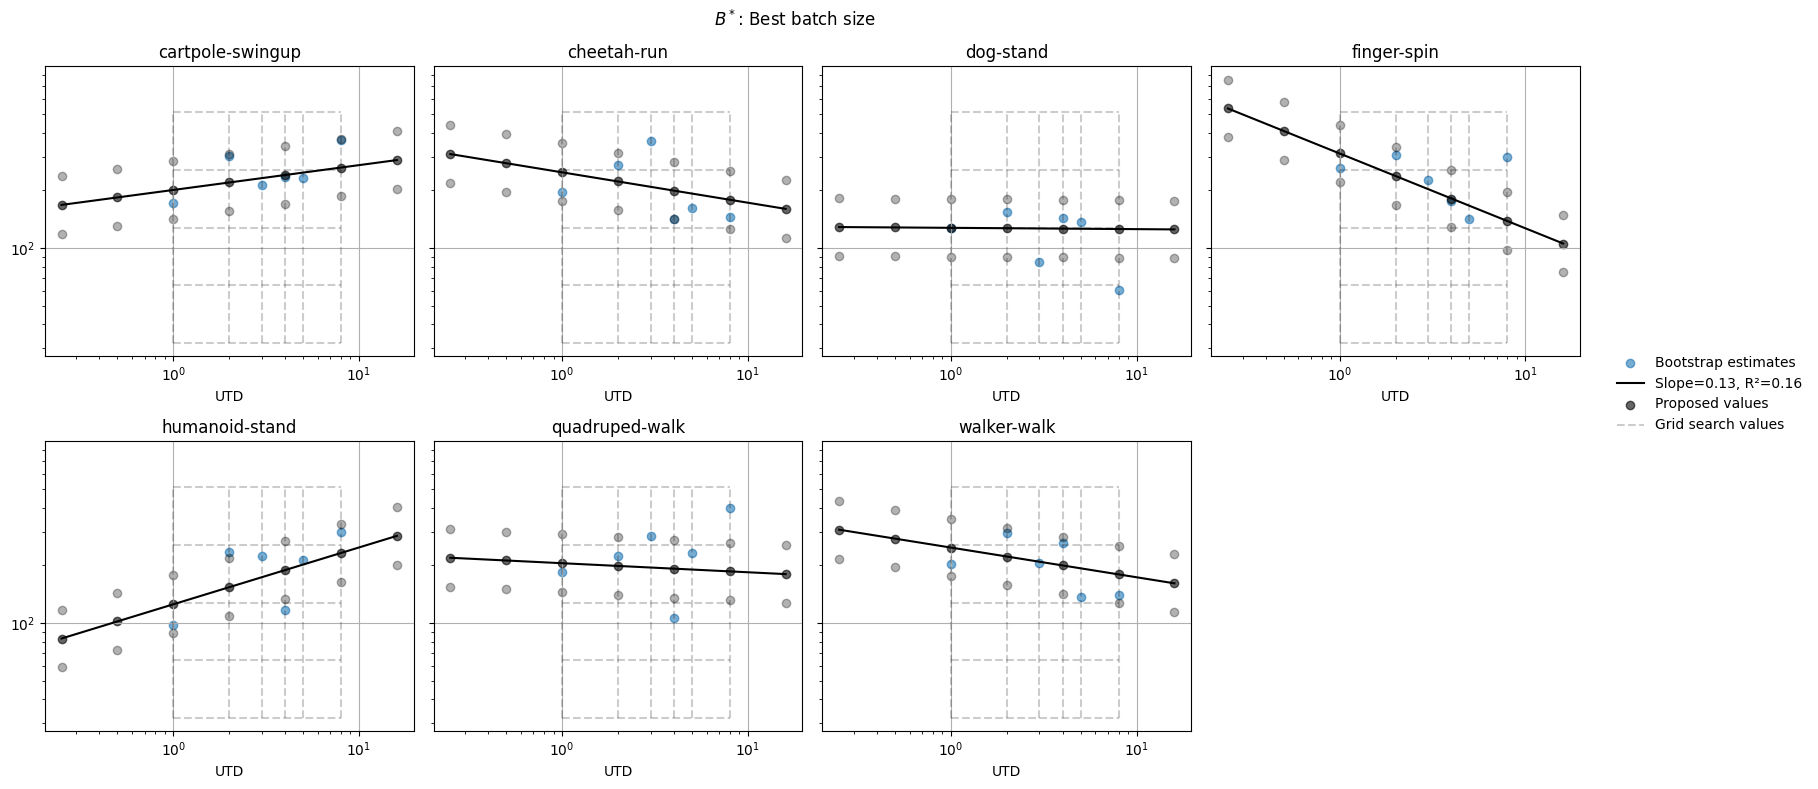

cartpole-swingup: bs ~ 0.000546 * UTD^-0.028664
cheetah-run: bs ~ 0.000467 * UTD^0.074974
dog-stand: bs ~ 0.000524 * UTD^0.034503
finger-spin: bs ~ 0.000498 * UTD^0.112526
humanoid-stand: bs ~ 0.000689 * UTD^-0.015594
quadruped-walk: bs ~ 0.000510 * UTD^0.079727
walker-walk: bs ~ 0.000538 * UTD^0.034251


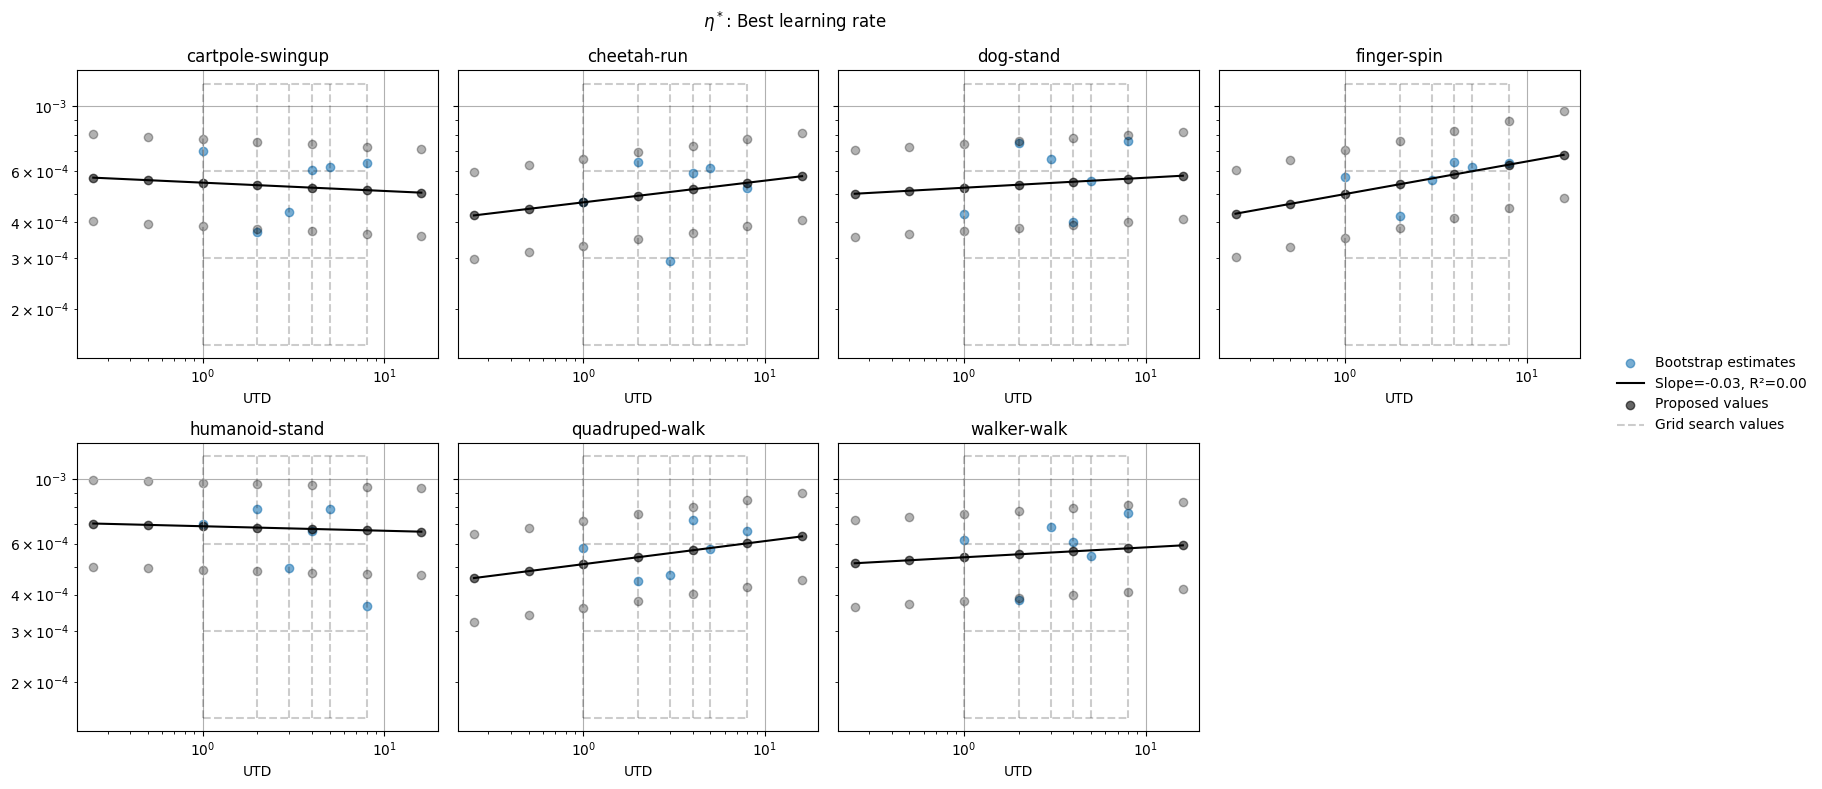

In [14]:
(
    proposed_lr_values_separate,
    proposed_bs_values_separate,
    lr_slopes_separate,
    lr_intercepts_separate,
    bs_slopes_separate,
    bs_intercepts_separate
) = linear_fit_separate(config.utds_to_predict, grid_search_df, best_lr_bs, plot=True)

cartpole-swingup: lr ~ 0.000514 * UTD^0.054981
cheetah-run: lr ~ 0.000474 * UTD^0.054981
dog-stand: lr ~ 0.000538 * UTD^0.054981
finger-spin: lr ~ 0.000533 * UTD^0.054981
humanoid-stand: lr ~ 0.000575 * UTD^0.054981
quadruped-walk: lr ~ 0.000533 * UTD^0.054981
walker-walk: lr ~ 0.000551 * UTD^0.054981


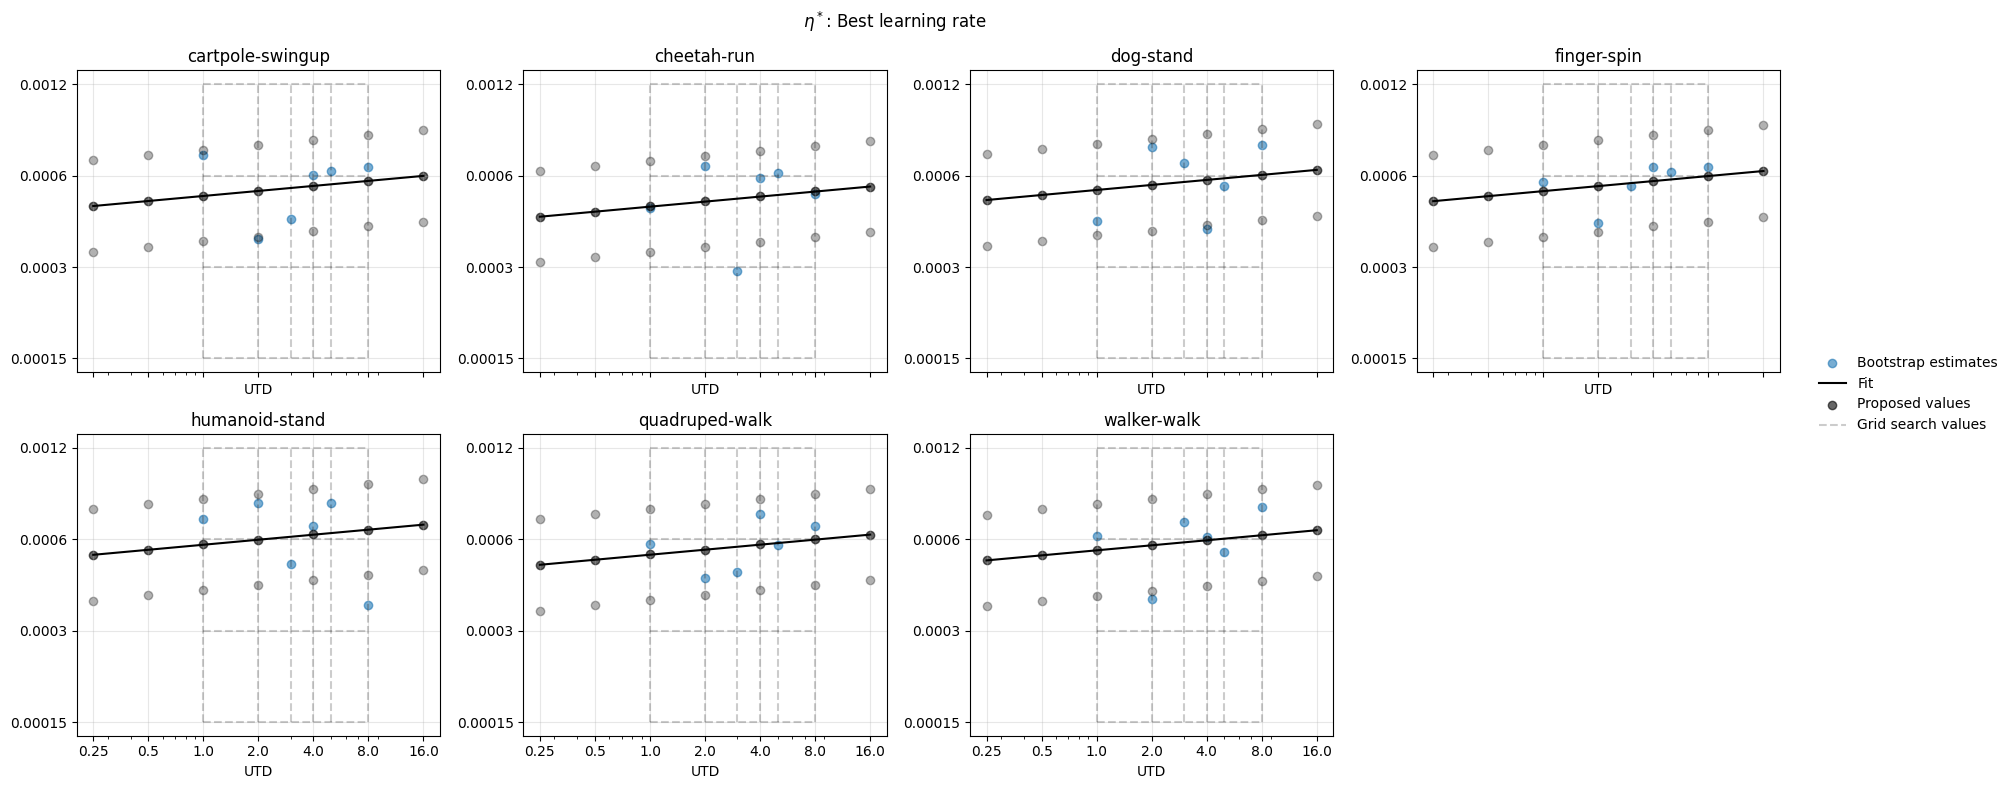

cartpole-swingup: batch size ~ 246.843352 * UTD^-0.000581
cheetah-run: batch size ~ 200.467029 * UTD^-0.000581
dog-stand: batch size ~ 112.182332 * UTD^-0.000581
finger-spin: batch size ~ 226.862506 * UTD^-0.000581
humanoid-stand: batch size ~ 183.556686 * UTD^-0.000581
quadruped-walk: batch size ~ 220.970519 * UTD^-0.000581
walker-walk: batch size ~ 199.395989 * UTD^-0.000581


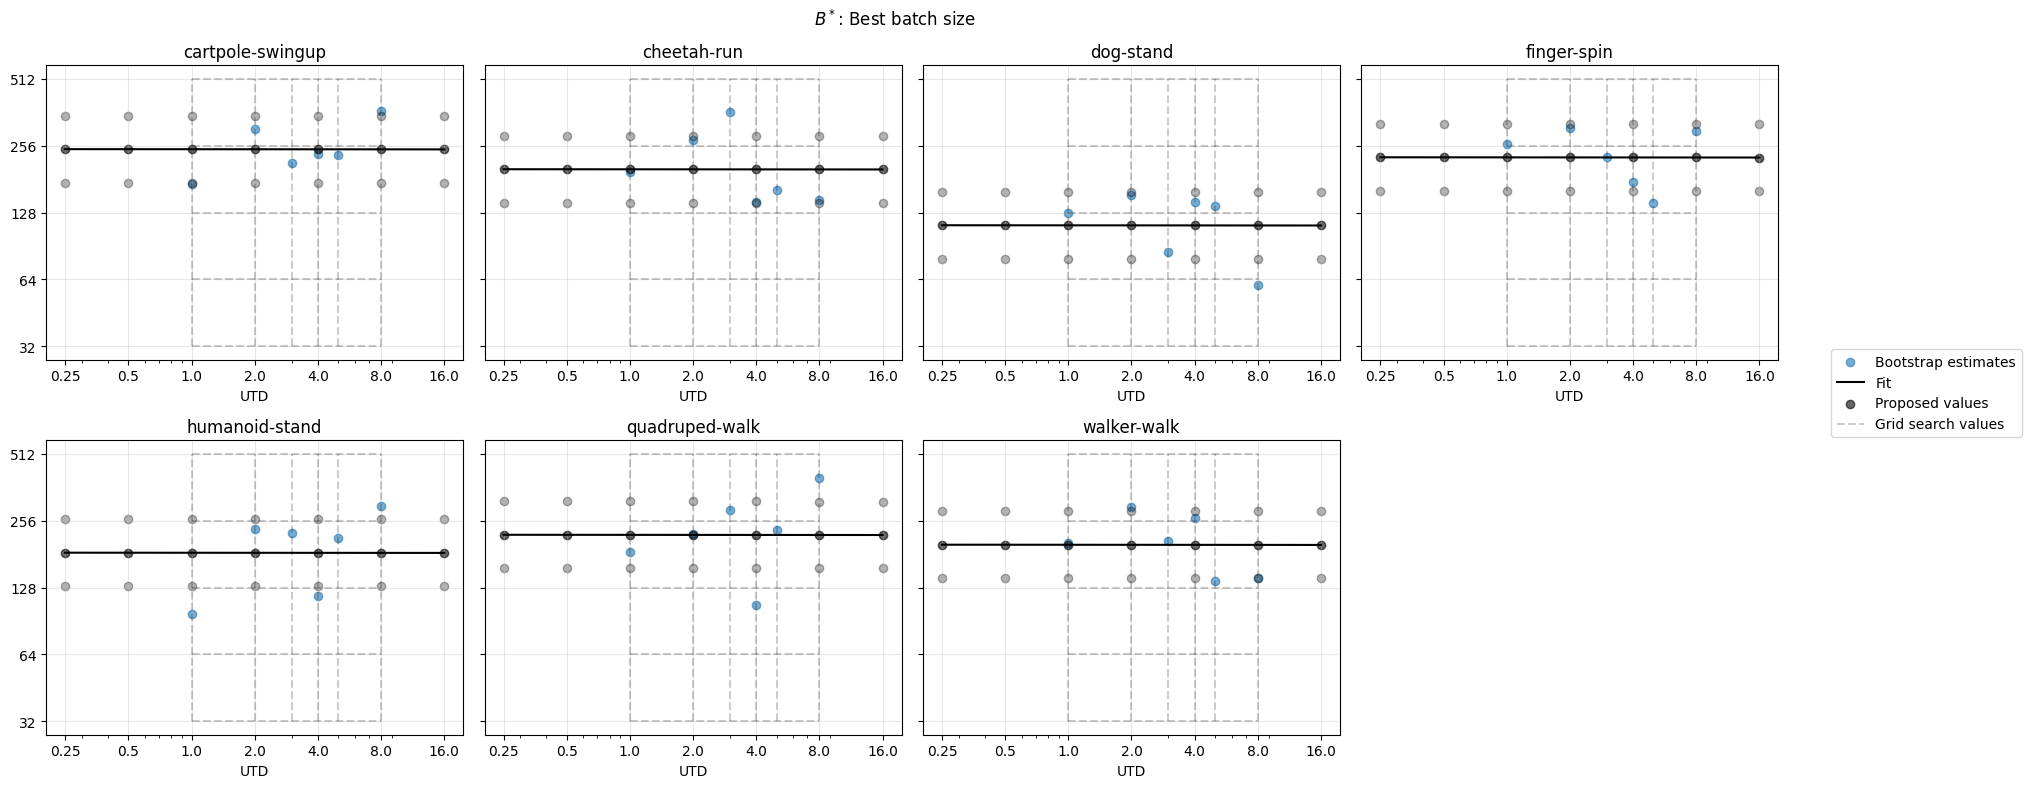

In [15]:
(
    proposed_lr_values,
    proposed_bs_values,
    lr_shared_slope,
    lr_env_intercepts,
    bs_shared_slope,
    bs_env_intercepts,
) = linear_fit_shared(config.utds_to_predict, grid_search_df, best_lr_bs, envs, name, plot=True)

In [16]:
pd.options.display.float_format = '{:.2e}'.format
proposed_values_df = tabulate_proposed_params(envs, config.utds_to_predict, proposed_lr_values, proposed_bs_values, name)
baseline_values_df = tabulate_baseline_params(grid_search_df, utds, config.utds_to_predict, len(envs), name)

Baseline based on UTD 2.0


/home/preston/value-scaling-workflow-private/qscaled/bootstrap_envsteps_to_thresh.py:1038: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  utd_data['last_crossing'] = utd_data['crossings'].apply(lambda x: x[-1])


In [17]:
proposed_values_df

Environment      UTD  Learning Rate  Learning Rate x√2  \
0   cartpole-swingup 2.50e-01       4.76e-04           6.74e-04   
1   cartpole-swingup 5.00e-01       4.95e-04           7.01e-04   
2   cartpole-swingup 1.00e+00       5.15e-04           7.29e-04   
3   cartpole-swingup 2.00e+00       5.35e-04           7.56e-04   
4   cartpole-swingup 4.00e+00       5.56e-04           7.86e-04   
5   cartpole-swingup 8.00e+00       5.77e-04           8.16e-04   
6   cartpole-swingup 1.60e+01       5.99e-04           8.47e-04   
7        cheetah-run 2.50e-01       4.39e-04           6.21e-04   
8        cheetah-run 5.00e-01       4.57e-04           6.46e-04   
9        cheetah-run 1.00e+00       4.75e-04           6.72e-04   
10       cheetah-run 2.00e+00       4.93e-04           6.97e-04   
11       cheetah-run 4.00e+00       5.13e-04           7.25e-04   
12       cheetah-run 8.00e+00       5.32e-04           7.53e-04   
13       cheetah-run 1.60e+01       5.52e-04           7.81e-04   
14         dog-stand 2.50e-01       4.99e-04           7.05e-04   
15         dog-stand 5.00e-01       5.19e-04           7.33e-04   
16         dog-stand 1.00e+00       5.39e-04           7.63e-04   
17         dog-stand 2.00e+00       5.60e-04           7.91e-04   
18         dog-stand 4.00e+00       5.82e-04           8.23e-04   
19         dog-stand 8.00e+00       6.04e-04           8.54e-04   
20         dog-stand 1.60e+01       6.27e-04           8.86e-04   
21       finger-spin 2.50e-01       4.94e-04           6.99e-04   
22       finger-spin 5.00e-01       5.14e-04           7.27e-04   
23       finger-spin 1.00e+00       5.35e-04           7.56e-04   
24       finger-spin 2.00e+00       5.55e-04           7.85e-04   
25       finger-spin 4.00e+00       5.77e-04           8.16e-04   
26       finger-spin 8.00e+00       5.99e-04           8.47e-04   
27       finger-spin 1.60e+01       6.21e-04           8.79e-04   
28    humanoid-stand 2.50e-01       5.33e-04           7.53e-04   
29    humanoid-stand 5.00e-01       5.54e-04           7.84e-04   
30    humanoid-stand 1.00e+00       5.76e-04           8.15e-04   
31    humanoid-stand 2.00e+00       5.98e-04           8.46e-04   
32    humanoid-stand 4.00e+00       6.22e-04           8.79e-04   
33    humanoid-stand 8.00e+00       6.45e-04           9.13e-04   
34    humanoid-stand 1.60e+01       6.70e-04           9.47e-04   
35    quadruped-walk 2.50e-01       4.94e-04           6.98e-04   
36    quadruped-walk 5.00e-01       5.14e-04           7.26e-04   
37    quadruped-walk 1.00e+00       5.34e-04           7.56e-04   
38    quadruped-walk 2.00e+00       5.54e-04           7.84e-04   
39    quadruped-walk 4.00e+00       5.77e-04           8.15e-04   
40    quadruped-walk 8.00e+00       5.98e-04           8.46e-04   
41    quadruped-walk 1.60e+01       6.21e-04           8.78e-04   
42       walker-walk 2.50e-01       5.11e-04           7.22e-04   
43       walker-walk 5.00e-01       5.31e-04           7.51e-04   
44       walker-walk 1.00e+00       5.52e-04           7.81e-04   
45       walker-walk 2.00e+00       5.73e-04           8.11e-04   
46       walker-walk 4.00e+00       5.96e-04           8.43e-04   
47       walker-walk 8.00e+00       6.19e-04           8.75e-04   
48       walker-walk 1.60e+01       6.42e-04           9.08e-04   

    Learning Rate x√0.5  Batch Size  Batch Size x√2  Batch Size x√0.5  \
0              3.37e-04         247             349               175   
1              3.50e-04         247             349               175   
2              3.64e-04         247             349               175   
3              3.78e-04         247             349               174   
4              3.93e-04         247             349               174   
5              4.08e-04         247             349               174   
6              4.23e-04         246             349               174   
7              3.11e-04         201             284               142   
8

In [18]:
baseline_values_df

Environment      UTD  Learning Rate  Batch Size
0   cartpole-swingup 2.50e-01       6.00e-04         512
1   cartpole-swingup 5.00e-01       6.00e-04         512
2   cartpole-swingup        1       6.00e-04         512
3   cartpole-swingup        2       6.00e-04         512
4   cartpole-swingup        4       6.00e-04         512
5   cartpole-swingup        8       6.00e-04         512
6   cartpole-swingup       16       6.00e-04         512
7        cheetah-run 2.50e-01       3.00e-04         256
8        cheetah-run 5.00e-01       3.00e-04         256
9        cheetah-run        1       3.00e-04         256
10       cheetah-run        2       3.00e-04         256
11       cheetah-run        4       3.00e-04         256
12       cheetah-run        8       3.00e-04         256
13       cheetah-run       16       3.00e-04         256
14         dog-stand 2.50e-01       3.00e-04         128
15         dog-stand 5.00e-01       3.00e-04         128
16         dog-stand        1       3.00e-04         128
17         dog-stand        2       3.00e-04         128
18         dog-stand        4       3.00e-04         128
19         dog-stand        8       3.00e-04         128
20         dog-stand       16       3.00e-04         128
21       finger-spin 2.50e-01       1.20e-03         512
22       finger-spin 5.00e-01       1.20e-03         512
23       finger-spin        1       1.20e-03         512
24       finger-spin        2       1.20e-03         512
25       finger-spin        4       1.20e-03         512
26       finger-spin        8       1.20e-03         512
27       finger-spin       16       1.20e-03         512
28    humanoid-stand 2.50e-01       1.50e-04         512
29    humanoid-stand 5.00e-01       1.50e-04         512
30    humanoid-stand        1       1.50e-04         512
31    humanoid-stand        2       1.50e-04         512
32    humanoid-stand        4       1.50e-04         512
33    humanoid-stand        8       1.50e-04         512
34    humanoid-stand       16       1.50e-04         512
35    quadruped-walk 2.50e-01       6.00e-04         128
36    quadruped-walk 5.00e-01       6.00e-04         128
37    quadruped-walk        1       6.00e-04         128
38    quadruped-walk        2       6.00e-04         128
39    quadruped-walk        4       6.00e-04         128
40    quadruped-walk        8       6.00e-04         128
41    quadruped-walk       16       6.00e-04         128
42       walker-walk 2.50e-01       6.00e-04         512
43       walker-walk 5.00e-01       6.00e-04         512
44       walker-walk        1       6.00e-04         512
45       walker-walk        2       6.00e-04         512
46       walker-walk        4       6.00e-04         512
47       walker-walk        8       6.00e-04         512
48       walker-walk       16       6.00e-04         512